# Autoencoders vs Principal Component Analysis

This notebook steps through the results generated in this paper: 
*Boe, David, et al. "Dimensionality Reduction of Human Gait for Prosthetic Control." Frontiers in Bioengineering and Biotechnology (2021): 925. https://www.frontiersin.org/articles/10.3389/fbioe.2021.724626/full*

We intend to compare the characteristics and performance of autoencoders and PCA when reducing the dimensionality of human gait. Human gait is highly complex, and it is not clear what advantages/disadvantages each method has.


### Library imports



In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
import keras
from keras import Model
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
#from keras import backend as K
from os import listdir
import seaborn as sns
from tqdm import tqdm
import torch
import glob
import math

from keras.utils.vis_utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz 2.44.1/bin/'

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#some stats for the unstructured dataset
jointMeans = [ 9.14982540e-01, -5.57923141e-01,  8.58194099e+00,  3.97530284e-01,
       -2.75233517e-01,  2.39274380e-02,  3.97521941e-01, -2.75248874e-01,
        3.81468753e+00,  3.01834808e-01, -1.95755853e-01,  6.66328151e+00,
       -1.46556269e+00, -6.45884522e-01,  1.78234918e+01, -2.89338041e+00,
       -7.06155534e-01, -3.06842586e+00, -3.88548529e+00,  2.49349467e+00,
       -3.84020964e+00,  1.69685072e+01,  7.69466709e+00,  3.03574202e+01,
       -1.87888355e+01,  8.05162624e+01,  5.37066871e+01,  4.25680264e+00,
       -2.40432863e+00, -1.12424281e+01, -9.20431037e+00, -1.56030651e-01,
       -6.85954946e-01,  1.65933537e+01,  9.86648041e+00,  2.59459165e+01,
       -1.79494344e+01,  7.48534138e+01,  5.75162114e+01,  2.78185577e+00,
       -2.82982243e+00, -7.73781232e+00,  2.83078114e-01, -5.28279397e+00,
        2.38722351e+01,  5.11016153e-01, -1.11771111e-01,  3.30879725e+01,
       -3.76676132e+00, -4.93506460e+00,  3.46075926e-01,  2.55396139e-01,
       -1.88380464e-02, -4.35061707e+00,  9.18342144e-01, -4.56721809e+00,
        2.50936774e+01,  1.23978922e-01, -4.51519003e-01,  3.59859526e+01,
       -4.47245222e+00, -3.20725701e+00,  1.16098368e+00,  6.31001977e-01,
        1.62218117e-01, -4.74804745e+00]

jointSTDs = [ 2.50769901,  2.89007328,  4.82135627,  1.09555453,  1.30328335,
        2.14172372,  1.09554141,  1.30329462,  2.14218764,  0.830996  ,
        0.97001108,  1.61093696,  4.19080449,  6.76506471,  4.84207178,
        6.16379998, 13.43315227,  8.9700052 ,  4.10752205,  4.53511891,
        4.86198016, 10.17279726, 15.33646364, 21.58296053, 16.32272061,
       29.76842195, 32.89011385, 13.18560507,  9.57721836, 15.69166059,
        3.87651068,  4.37787549,  4.98784298,  9.57856384, 16.23952042,
       22.12710705, 15.26502725, 28.89684133, 34.00353878, 14.30201682,
        9.81932319, 16.70823703,  6.52667298,  7.98732672, 19.44770783,
        3.75892505,  4.75493904, 20.53642448,  7.23816215, 10.43597269,
        9.72810384,  4.37845825,  1.25844709,  9.66427248,  6.20870119,
        7.46777365, 19.73792051,  3.57618016,  4.07928902, 20.12362033,
        7.26039667, 10.74356634, 10.38937948,  4.40461265,  1.43114816,
        9.88812903]

jointLabels = ['ang_jL5S1_Frontal', 'ang_jL5S1_Trans', 'ang_jL5S1_Sagittal', 'ang_jL4L3_Frontal', 
               'ang_jL4L3_Trans', 'ang_jL4L3_Sagittal', 'ang_jL1T12_Frontal', 'ang_jL1T12_Trans',
               'ang_jL1T12_Sagittal', 'ang_jT9T8_Frontal', 'ang_jT9T8_Trans', 'ang_jT9T8_Sagittal',
               'ang_jT1C7_Frontal', 'ang_jT1C7_Trans', 'ang_jT1C7_Sagittal', 'ang_jC1Head_Frontal',
               'ang_jC1Head_Trans', 'ang_jC1Head_Sagittal', 'ang_jRightT4Shoulder_Frontal', 
               'ang_jRightT4Shoulder_Trans', 'ang_jRightT4Shoulder_Sagittal', 'ang_jRightShoulder_Frontal',
               'ang_jRightShoulder_Trans', 'ang_jRightShoulder_Sagittal', 'ang_jRightElbow_Frontal', 
               'ang_jRightElbow_Trans', 'ang_jRightElbow_Sagittal', 'ang_jRightWrist_Frontal',
               'ang_jRightWrist_Trans', 'ang_jRightWrist_Sagittal', 'ang_jLeftT4Shoulder_Frontal',
               'ang_jLeftT4Shoulder_Trans', 'ang_jLeftT4Shoulder_Sagittal', 'ang_jLeftShoulder_Frontal', 
               'ang_jLeftShoulder_Trans', 'ang_jLeftShoulder_Sagittal', 'ang_jLeftElbow_Frontal', 
               'ang_jLeftElbow_Trans', 'ang_jLeftElbow_Sagittal', 'ang_jLeftWrist_Frontal', 'ang_jLeftWrist_Trans', 
               'ang_jLeftWrist_Sagittal', 'ang_jRightHip_Frontal', 'ang_jRightHip_Trans',
               'ang_jRightHip_Sagittal', 'ang_jRightKnee_Frontal', 'ang_jRightKnee_Trans', 
               'ang_jRightKnee_Sagittal', 'ang_jRightAnkle_Frontal', 'ang_jRightAnkle_Trans', 
               'ang_jRightAnkle_Sagittal', 'ang_jRightBallFoot_Frontal', 'ang_jRightBallFoot_Trans', 
               'ang_jRightBallFoot_Sagittal', 'ang_jLeftHip_Frontal', 'ang_jLeftHip_Trans', 
               'ang_jLeftHip_Sagittal', 'ang_jLeftKnee_Frontal', 'ang_jLeftKnee_Trans', 'ang_jLeftKnee_Sagittal', 
               'ang_jLeftAnkle_Frontal', 'ang_jLeftAnkle_Trans', 'ang_jLeftAnkle_Sagittal', 
               'ang_jLeftBallFoot_Frontal', 'ang_jLeftBallFoot_Trans', 'ang_jLeftBallFoot_Sagittal']

c:\users\david\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\client\session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# Import data

We use 3 datasets for this study. 

First, a flatground walking dataset we collected using the XSENS wearable motion capture system. Participants walked down a long public corridor while we recorded their joint movements. We process the resulting signal to obtain 60 Hz signals representing a 1x3 Euler of each major joint in the lower body (hips, knees, ankles). We drop some planes of movement because they are just noise - namely coronal and transverse movement of the knee.

Second, a stairs dataset, collected in a similar fashion. Participants descended and ascended a 13 step real world staircase as described here: *Sie, Astrini, et al. "Descending 13 real world steps: a dataset and analysis of stair descent." Gait & Posture (2021). A subset of that data was used here, and processed as described above.*

Third, we used an unstructured dataset from *Geissinger, J. H., and Asbeck, A. T. (2020a). Motion Inference Using Sparse Inertial Sensors, Self-Supervised Learning, and a New Dataset of Unscripted Human Motion. Sensors 20, 6330. doi:10.3390/s20216330.* This dataset represents the full complexity of human movement, and was recorded using XSENS from participants who were not given any scripted activities, but simply living their life.

Code below is used to process data for machine learning purposes. The data files are too large to host, but can be shared if asked nicely :)

Note that some data is processed to include entire sequences of movements, rather than snapshot poses. However, for Pose-AE and PCA, we will simply use the first timestep of each sample.

### Flatground

In [26]:
legs = [42, 43, 44, 47, 48, 49, 50, 54, 55, 56, 59, 60, 61, 62]
dataset = h5py.File(r'Z:\uncompressed-dataset\special\train-flat-legs.hdf5', 'r')
x_train = []
for key in dataset.keys():
    x_train.append(dataset[key][:,:,:]) 
x_train = np.array(x_train[0])
skipFrames = np.arange(0,x_train.shape[0],10)
x_train_flat = x_train[skipFrames,0,:]


dataset = h5py.File(r'Z:\uncompressed-dataset\special\test-flat-legs.hdf5', 'r')
x_test = []
for key in dataset.keys():
    x_test.append(dataset[key][:,:,:]) 
x_test = np.array(x_test[0])
skipFrames = np.arange(0,x_test.shape[0],10)
x_test_flat = x_test[skipFrames,0,:]


print(x_train_flat.shape)
print(x_test_flat.shape)

(38196, 14)
(6649, 14)


In [29]:
legs = [42, 43, 44, 47, 48, 49, 50, 54, 55, 56, 59, 60, 61, 62]
dataset = h5py.File(r'Z:\uncompressed-dataset\special\train-flat-subjects.hdf5', 'r')
x_train = []
temp = []
currentKey = '11'
for key in dataset.keys():
    if key.split('-')[0] == currentKey:
        temp.append(dataset[key][:,:,:])
    else:
        temp = np.vstack(temp)
        x_train.append(temp)
        temp = []
        temp.append(dataset[key][:,:,:])
    currentKey = key.split('-')[0]
temp = np.vstack(temp)
x_train.append(temp)
x_train_flat_all = x_train.copy()
indices = []
indices.append(0)
for s in range(len(x_train)):
    skipFrames = np.arange(0,x_train[s].shape[0],10)
    x_train[s] = x_train[s][skipFrames]
    print(x_train[s].shape)
    indices.append(x_train[s].shape[0])
indices = np.cumsum(indices)
x_train_flat = np.vstack(x_train)
print(x_train_flat.shape)
print(indices)

(1590, 60, 14)
(3403, 60, 14)
(1955, 60, 14)
(5147, 60, 14)
(5853, 60, 14)
(1252, 60, 14)
(7886, 60, 14)
(8325, 60, 14)
(35411, 60, 14)
[    0  1590  4993  6948 12095 17948 19200 27086 35411]


### Stairs

In [6]:
legs = [42, 43, 44, 47, 48, 49, 50, 54, 55, 56, 59, 60, 61, 62]
dataset = h5py.File(r'Z:\uncompressed-dataset\special\train2-stairs-legs.hdf5', 'r')
x_train = []
for key in dataset.keys():
    x_train.append(dataset[key][:,:,:]) 
x_train = np.array(x_train[0])
skipFrames = np.arange(0,x_train.shape[0],10)
x_train_stairs = x_train[skipFrames,:,:]


dataset = h5py.File(r'Z:\uncompressed-dataset\special\test2-stairs-legs.hdf5', 'r')
x_test = []
for key in dataset.keys():
    x_test.append(dataset[key][:,:,:]) 
x_test = np.array(x_test[0])
skipFrames = np.arange(0,x_test.shape[0],10)
x_test_stairs = x_test[skipFrames,:,:]


print(x_train_stairs.shape)
print(x_test_stairs.shape)

(54755, 60, 14)
(12326, 60, 14)


### Unstructured

In [7]:
legs = [42, 43, 44, 47, 48, 49, 50, 54, 55, 56, 59, 60, 61, 62]
dataset = h5py.File('Z:\processed-dataset\downsampled/train_unstructured_windowOne_standardized.hdf5', 'r')
x_train = []

joints = legs

for key in dataset.keys():
    x_train.append(dataset[key][:,:,joints]) 

x_all = np.concatenate(x_train, axis = 0) #convert to np array
x_all = np.reshape(x_all,(x_all.shape[0],x_all.shape[2]))
skipFrames = np.arange(0,x_all.shape[0],10)
x_train_unstructured = x_all[skipFrames]


dataset = h5py.File('Z:\processed-dataset\downsampled/test_unstructured_windowOne_standardized.hdf5', 'r')
x_train = []

for key in dataset.keys():
    x_train.append(dataset[key][:,:,joints]) 

x_all = np.concatenate(x_train, axis = 0) #convert to np array
x_all = np.reshape(x_all,(x_all.shape[0],x_all.shape[2]))
skipFrames = np.arange(0,x_all.shape[0],10)
x_test_unstructured = x_all[skipFrames]
#prep output into list for multiheaded network

print(x_train_unstructured.shape)
print(x_test_unstructured.shape)


(34779, 14)
(5226, 14)


# Functions

In [15]:
def train_num_iterations(model, x_train, y_train, batch_size, maxIterations):
    for it in range(maxIterations):
        ids = np.random.randint(0, x_train.shape[0], batch_size)
        x_signals = x_train[ids]
        y_signals = y_train[ids]
        model.train_on_batch(x_signals, y_signals)
        #model.train_on_batch(x_train, x_train)
        print("Training... " + "{:.2f}".format((it/maxIterations)*100) + '%', end = '\r', flush = True)
    return model

def create_autoencoder_final(latent_dim, input_dim, para_latent_dim):
    input_layer = Input(shape=(input_dim))
    
    encoder = Dense(28, activation = 'tanh')(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = Dense(14, activation = 'tanh')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dense(para_latent_dim, activation = 'tanh')(encoder)
    
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    
    decoder = Dense(para_latent_dim, activation = 'tanh')(latent)
    decoder = Dense(14, activation = 'tanh')(decoder)
    decoder = Dense(14, activation = 'linear')(decoder)
    
    return Model(input_layer, decoder)

def create_autoencoder_deep(latent_dim, input_dim, para_latent_dim):
    input_layer = Input(shape=(input_dim))
    
    encoder = Dense(28, activation = 'tanh')(input_layer)
    #encoder = BatchNormalization()(encoder)
    encoder = Dense(14, activation = 'tanh')(encoder)
    #encoder = BatchNormalization()(encoder)
    encoder = Dense(para_latent_dim, activation = 'tanh')(encoder)
    
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    
    decoder = Dense(para_latent_dim, activation = 'tanh')(latent)
    decoder = Dense(14, activation = 'tanh')(decoder)
    decoder = Dense(14, activation = 'linear')(decoder)
    
    error = Subtract()([input_layer, decoder])
    
    return Model(input_layer, decoder)

def create_autoencoder_deepCustomWidth_customActivation(latent_dim, input_dim, para_latent_dim, width_mult, activation):
    input_layer = Input(shape=(input_dim))
    
    encoder = Dense(14*width_mult, activation = activation)(input_layer)
    #encoder = BatchNormalization()(encoder)
    encoder = Dense(14*np.clip(width_mult-1, 1, 4), activation = activation)(encoder)
    #encoder = BatchNormalization()(encoder)
    encoder = Dense(para_latent_dim * np.clip(width_mult-2, 1, 4), activation = activation)(encoder)
    
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    
    decoder = Dense(para_latent_dim * np.clip(width_mult-2, 1, 4), activation = activation)(latent)
    decoder = Dense(14*np.clip(width_mult-1, 1, 4), activation = activation)(decoder)
    decoder = Dense(14, activation = 'linear')(decoder)
    
    error = Subtract()([input_layer, decoder])
    
    return Model(input_layer, decoder)

def create_autoencoder_shallowCustomWidth(latent_dim, input_dim, para_latent_dim, width_mult):
    input_layer = Input(shape=(input_dim))
    encoder = Dense(para_latent_dim*width_mult, activation = 'tanh')(input_layer)
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    decoder = Dense(14, activation = 'linear')(latent)
    return Model(input_layer, decoder)

def create_autoencoder_intermediateCustomWidth(latent_dim, input_dim, para_latent_dim, width_mult):
    input_layer = Input(shape=(input_dim))
    
    encoder = Dense(14*width_mult, activation = 'tanh')(input_layer)
    encoder = Dense(para_latent_dim*np.clip(width_mult-1, 1, 4), activation = 'tanh')(encoder)
    
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    
    decoder = Dense(para_latent_dim * np.clip(width_mult-1, 1, 4), activation = 'tanh')(latent)
    decoder = Dense(14, activation = 'linear')(decoder)
    
    return Model(input_layer, decoder)



def create_autoencoder_shallow(latent_dim, input_dim):
    input_layer = Input(shape=(input_dim))
    encoder = Dense(14, activation = 'tanh')(input_layer)
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    decoder = Dense(14, activation = 'linear')(latent)
    
    error = Subtract()([input_layer, decoder])
    
    return Model(input_layer, decoder)

def create_autoencoder_dual_input(latent_dim, input_dim):
    input_layer = Input(shape=(input_dim))
    
    encoder = Dense(28, activation = 'tanh')(input_layer)
    #encoder = BatchNormalization()(encoder)
    encoder = Dense(14, activation = 'tanh')(encoder)
    #encoder = BatchNormalization()(encoder)
    encoder = Dense(7, activation = 'tanh')(encoder)
    
    encoder2 = Dense(28, activation = 'tanh')(input_layer)
    #encoder2 = BatchNormalization()(encoder2)
    encoder2 = Dense(14, activation = 'tanh')(encoder2)
    #encoder2 = BatchNormalization()(encoder2)
    encoder2 = Dense(7, activation = 'tanh')(encoder2)
    
    latent = Dense(latent_dim, activation = 'linear')(encoder)
    latent2 = Dense(1, activation = 'linear')(encoder2)
    
    decoder = Concatenate()([latent, latent2])
    decoder = Dense(7, activation = 'tanh')(decoder)
    decoder = Dense(14, activation = 'tanh')(decoder)
    decoder = Dense(14, activation = 'tanh')(decoder)
    
    error = Subtract()([input_layer, decoder])
    
    return Model(input_layer, decoder)

def generate_spatial_variance_map_AE(decoder, activations, xbounds, ybounds):
    #SPATIAL LANDSCAPE VISUALIZATION
    #define grid of testing points
    #iterate through the grid
    #at each point, generate gaussian sampling of local area
    #decode the results, find variance of decoded samples
    #store variance for each grid point

    xGrid = np.linspace(xbounds[0],xbounds[1],200)
    yGrid = np.linspace(ybounds[0],ybounds[1],200)

    spatialMap = np.zeros((200,200))

    for x in range(len(xGrid)):
        for y in range(len(yGrid)):
            samples = np.array([np.random.normal(xGrid[x], 0.1, 100), np.random.normal(yGrid[y], 0.1, 100)])
            samples = np.swapaxes(samples, 0, 1)
            samDec = decoder(samples)
            spatialMap[x,y] = np.mean(np.var(samDec, axis = 0))

    import scipy as sp
    import scipy.ndimage
    
    spatialMap = np.swapaxes(spatialMap, 0, 1)
    spatialMap = np.flip(spatialMap, 0)
    smoothMap = sp.ndimage.filters.gaussian_filter(spatialMap, [1,1], mode='constant')

    import plotly.graph_objects as go

    #plt.figure(0)
    #fig = go.Figure(data=[go.Surface(z=smoothMap)])
    #fig.update_layout(title='Spatial Landscape', autosize=True,
    #                  width=500, height=500,
    #                  margin=dict(l=65, r=50, b=65, t=90))
    #fig.show()

    plt.figure(1)
    plt.imshow(smoothMap, cmap='hot', extent = (xbounds[0],xbounds[1], ybounds[0],ybounds[1]), vmin = 0, vmax = 0.2)
    plt.xlim(xbounds[0],xbounds[1])
    plt.ylim(ybounds[0],ybounds[1])
    plt.clim(0, 0.2)
    plt.colorbar()
    #plt.scatter(activations[:,0],activations[:,1],s=1.5,color = (0,1,0), alpha = 0.5)
    
def generate_temporal_variance_map(activations, xbounds, ybounds):
    import plotly.graph_objects as go
    #TEMPORAL LANDSCAPE VISUALIZATION
    #differentiate activations using einsum
    #bin them by x,y coord
    #smooth and plot
    
    from scipy import stats
    def einsum(v, u):
       z = v - u
       return np.sqrt(np.einsum('i,i->', z, z))

    repDist = np.zeros(activations.shape[0]-1)
    for r in range(activations.shape[0]-1):
        repDist[r] = (einsum(activations[r], activations[r+1]))

    binnedStat = stats.binned_statistic_2d(activations[:-1,0], activations[:-1,1], repDist, bins = [50,50])
    binnedData = binnedStat[0]
    binnedData = np.swapaxes(binnedData, 0, 1)
    binnedData = np.flip(binnedData, 0)
    print(binnedData.shape)
    import scipy as sp
    import scipy.ndimage
    smoothMap = binnedData #sp.ndimage.filters.gaussian_filter(binnedData, [1,1], mode='constant')
    print(smoothMap.shape)
    plt.figure(3)
    fig = go.Figure(data=[go.Surface(z=smoothMap)])
    fig.update_layout(title='Spatial Landscape', autosize=True,
                      width=500, height=500,
                      margin=dict(l=65, r=50, b=65, t=90))

    plt.figure(4)
    plt.imshow(smoothMap, cmap='hot', extent = (xbounds[0],xbounds[1], ybounds[0],ybounds[1]))#, vmin = 0, vmax = 0.2)
    plt.xlim(xbounds[0],xbounds[1])
    plt.ylim(ybounds[0],ybounds[1])
    plt.clim(0,8)
    plt.colorbar()
    #plt.scatter(activations[:,0],activations[:,1],s=1.5,color = (0,1,0), alpha = 0.5)
    
def generate_spatial_variance_map_PCA(pca, activations, xbounds, ybounds):
    import plotly.graph_objects as go
    #SPATIAL LANDSCAPE VISUALIZATION
    #define grid of testing points
    #iterate through the grid
    #at each point, generate gaussian sampling of local area
    #decode the results, find variance of decoded samples
    #store variance for each grid point

    xGrid = np.linspace(xbounds[0],xbounds[1],200)
    yGrid = np.linspace(ybounds[0],ybounds[1],200)

    spatialMap = np.zeros((200,200))

    for x in range(len(xGrid)):
        for y in range(len(yGrid)):
            samples = np.array([np.random.normal(xGrid[x], 0.1, 100), np.random.normal(yGrid[y], 0.1, 100)])
            samples = np.swapaxes(samples, 0, 1)
            samples = np.hstack([samples, np.zeros((100,12))])
            samDec = pca.inverse_transform(samples)
            spatialMap[x,y] = np.mean(np.var(samDec, axis = 0))

    import scipy as sp
    import scipy.ndimage
    
    spatialMap = np.swapaxes(spatialMap, 0, 1)
    spatialMap = np.flip(spatialMap, 0)
    smoothMap = sp.ndimage.filters.gaussian_filter(spatialMap, [1,1], mode='constant')

    plt.figure(0)
    plt.imshow(smoothMap, cmap='hot', extent = (xbounds[0],xbounds[1], ybounds[0],ybounds[1]), vmin = 0, vmax = 0.2)
    #plt.scatter(activations[:,0],activations[:,1],s=0.5,color = (0,1,0), alpha = 0.5)
    plt.xlim(xbounds[0],xbounds[1])
    plt.ylim(ybounds[0],ybounds[1])
    plt.clim(0, 0.2)
    plt.colorbar()

# Hyperparameter sweep

To make a good comparison, we need to make an autoencoder that is optimized for human gait. However, we should be cognizant of how easy it is to overfit hyperparameters, so we include two constraints:

1. Use a single subject (subject 1).

2. Use a single data type (flatground walking).

Ultimately, we do not need to optimize too much, as long as we keep our hyperparameters constant throughout the experiment.

An heuristic search was performed across 5 hyperparameters - optimizer, learning rate, layer width, layer depth, and activation function. The final choices are commented respectively. The code for testing the various parameters were not included here for ease of reading. Note that layer width refers to a multiplier on the input dimension, so a layer width of 2 means a 14 dimension signal is passed into a 28 unit wide layer.

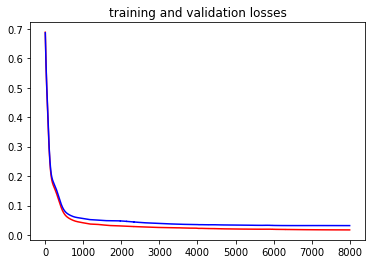

In [24]:
#hyperparams to test...
opts = [SGD, Adam] #Adam,
lrs = [0.01, 0.001, 0.0001] #0.001
layer_width = [1, 2, 3] #2
layer_depth = [1, 2, 3] #3
activations = ['tanh','sigmoid','relu'] #tanh

#set up the autoencoder dimensions
input_dim = x_train_flat.shape[2]
latent_dim = 2
para_latent_dim = 7

#losses logged here
val_losses = []
losses = []

#build the autoencoder architecture
ae = create_autoencoder_final(latent_dim, input_dim, para_latent_dim)
optimizer = Adam(learning_rate = 0.001)
ae.compile(loss='mse', loss_weights=1, optimizer=optimizer)

#manual training loop, with full batch gradient descent. reduce iterations if training on CPU. paper uses 8000 epochs,
#but for demonstration purposes let's just use 400
for i in range(400):
    ae.train_on_batch(x_train_flat[:800,0,:], x_train_flat[:800,0,:])
    dec = ae.predict_on_batch(x_train_flat[800:1600,0,:])
    loss = ((x_train_flat[800:1600,0,:] - dec) ** 2).mean()
    val_losses.append(loss)
    dec = ae.predict_on_batch(x_train_flat[:800,0,:])
    loss = ((x_train_flat[:800,0,:] - dec) ** 2).mean()
    losses.append(loss)
    print("Training... " + "{:.2f}".format((i/8000)*100) + '%', end = '\r', flush = True)

plt.figure(0)
plt.title("training and validation losses")
plt.plot(losses, color = 'red')
plt.plot(val_losses, color = 'blue')

Model converges nicely, so we declare these hyperparameters good. The final architecture for Pose-AE looks like this. Move-AE is addressed in another notebook.

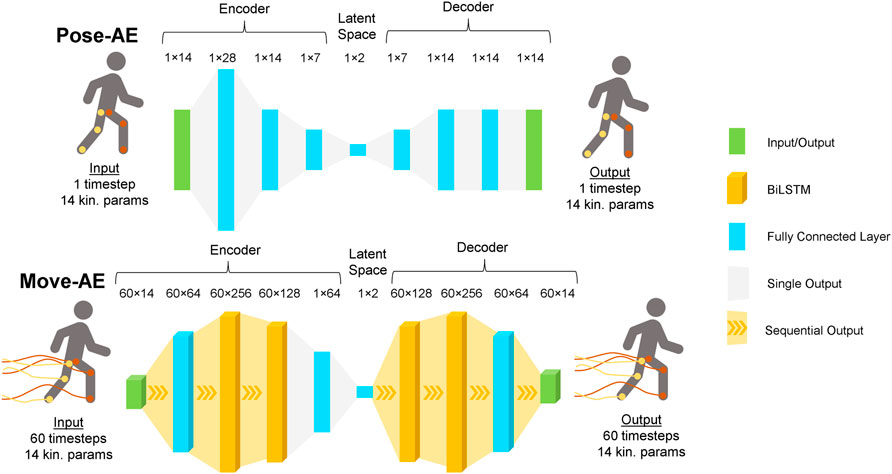

In [25]:
ae.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense_42 (Dense)             (None, 28)                420       
_________________________________________________________________
batch_normalization_12 (Batc (None, 28)                112       
_________________________________________________________________
dense_43 (Dense)             (None, 14)                406       
_________________________________________________________________
batch_normalization_13 (Batc (None, 14)                56        
_________________________________________________________________
dense_44 (Dense)             (None, 7)                 105       
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 16  

# Train autoencoders on full data

For each of the 3 data types (flatground, stairs, unstructured), we will now train our autoencoder. We will also vary the size of the latent dimension. If we treat each latent dimension as a principal component, we can later compare reconstruction performance from an identical number of latent dimensions/PCs.

For curiosity's sake, we will also visualize variance across the latent manifold for each data type. This gives us an idea about how our latent space is warping the data in Euclidean space, and hints at the existence of fractures - a known problem for autoencoders. 

## Flatground data

In [85]:
dimvar_flat = [] # save this for later comparison

hist = []
losses_train = []
losses_test = []

ae_vaf_test_flat = []
ae_vaf_train_flat = []
input_dim = x_train_flat.shape[2]
latent_dim = 2

for d in range(1,15):
    #Training loop
    latent_dim = d
    ae = create_autoencoder_final(latent_dim, input_dim, np.clip(latent_dim,7,15))
    opt = Adam(learning_rate=0.001)
    ae.compile(loss='mse', loss_weights=1, optimizer=opt)
    #K.set_value(ae.optimizer.learning_rate, 0.001)
    ae = train_num_iterations(ae, x_train_flat[:,0,:], x_train_flat[:,0,:], 32, 8000)
    
    #Gets latent activations 
    inputLayer = Input(shape = (x_train_flat.shape[2]))    
    embedder = inputLayer
    for layer in ae.layers[:7]:
        embedder = layer(embedder)
    embedder = Model(inputs=inputLayer, outputs=embedder)
    activations = embedder(x_train_flat[:,0,:])
    
    #Save dimensional variance statistics for later comparison
    dimvartemp = []
    for u in range(activations.shape[1]):
        dimvartemp.append(np.var(activations[:,u]))
    print(activations.shape)
    dimvar_flat.append(dimvartemp)
    
    #Track Variance Accounted For and loss as latent space inflates
    dec = ae.predict(x_test_flat)
    loss = ((x_test_flat - dec) ** 2).mean()
    losses_test.append(loss)
    ae_vaf_test_flat.append((1 - ((np.var(x_test_flat - dec)) / (np.var(x_test_flat)))) * 100)
    
    dec = ae.predict(x_train_flat[:,0,:])
    loss = ((x_train_flat[:,0,:] - dec) ** 2).mean()
    losses_train.append(loss)
    ae_vaf_train_flat.append((1 - ((np.var(x_train_flat[:,0,:] - dec)) / (np.var(x_train_flat[:,0,:])))) * 100)
    
    print('Latent dim: ' + str(d) + ' with train loss: ' + str(loss))

(35411, 1). 99.99%
Latent dim: 1 with train loss: 0.21990660440984103
(35411, 2). 99.99%
Latent dim: 2 with train loss: 0.1626734837683208
(35411, 3). 99.99%
Latent dim: 3 with train loss: 0.12693295934407492
(35411, 4). 99.99%
Latent dim: 4 with train loss: 0.10349781070003941
(35411, 5). 99.99%
Latent dim: 5 with train loss: 0.09177394897845381
(35411, 6). 99.99%
Latent dim: 6 with train loss: 0.07587375575801213
(35411, 7). 99.99%
Latent dim: 7 with train loss: 0.0685903071183463
(35411, 8). 99.99%
Latent dim: 8 with train loss: 0.058739517185316115
(35411, 9). 99.99%
Latent dim: 9 with train loss: 0.04966226012027041
(35411, 10) 99.99%
Latent dim: 10 with train loss: 0.03777403677942861
(35411, 11) 99.99%
Latent dim: 11 with train loss: 0.03651294484953572
(35411, 12) 99.99%
Latent dim: 12 with train loss: 0.027335835155810534
(35411, 13) 99.99%
Latent dim: 13 with train loss: 0.01973877901028283
(35411, 14) 99.99%
Latent dim: 14 with train loss: 0.019506964016410725


### Train a final model for safekeeping

In [57]:
input_dim = x_train_flat.shape[2]
latent_dim = 2
ae = create_autoencoder_final(2, input_dim, 7)
opt = Adam(learning_rate=0.001)
ae.compile(loss='mse', loss_weights=1, optimizer=opt)
ae.fit(x_train_flat, x_train_flat, epochs = 25, batch_size = 32, verbose = 0)
ae.save('models/ae-flat.h5')

### Plot the latent space and ~1 gait cycle

We see that the autoencoder embeds our gait in a latent cyclic structure. In fact, if you investigate further, you find that the radius of the structure encodes cadence, while the angle encodes phase. Thus, our autoencoder is learning to represent gait as any expert might - if you know the cadence and phase you can reconstruct it.

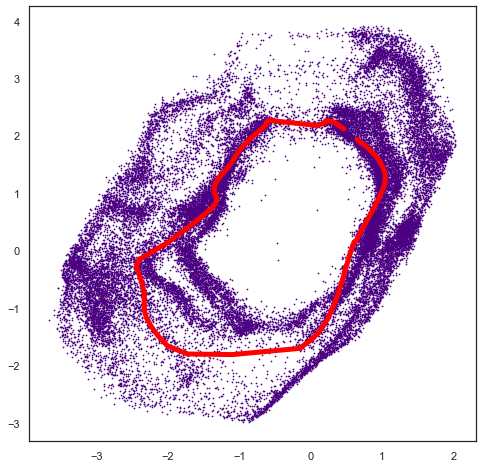

In [45]:
#Get the encoder, get the latent activations
ae = keras.models.load_model('models/ae-flat.h5') #Or any model with a 2-dimensional bottleneck
inputLayer = Input(shape = (14))    
embedder = inputLayer
for layer in ae.layers[:7]:
    embedder = layer(embedder)
embedder = Model(inputs=inputLayer, outputs=embedder)
activations = embedder(x_train_flat[:,0,:])

#Plot the latent activations
sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})
plt.scatter(activations[:,0],activations[:,1],s=0.5,color = 'indigo')

#Get a random sequence and plot it
cycleSample = []
for t in range(60):
    acts = embedder(x_train_flat[1000:1001,t,:])
    cycleSample.append(acts)
plt.plot(np.squeeze(np.array(cycleSample))[:,0],np.squeeze(np.array(cycleSample))[:,1], color = 'red', linewidth = 5)

### Spatiotemporal landscape

We can plot spatial and temporal features in the latent space. 

Here, "spatial variance" for a given point is determined by sampling from a distribution centered on the point in the latent space, then calculating the variance of the decoded samples. One could interpret areas of higher variance in several ways - they indicate potential fractures in the manifold, or potentially areas of low confidence.

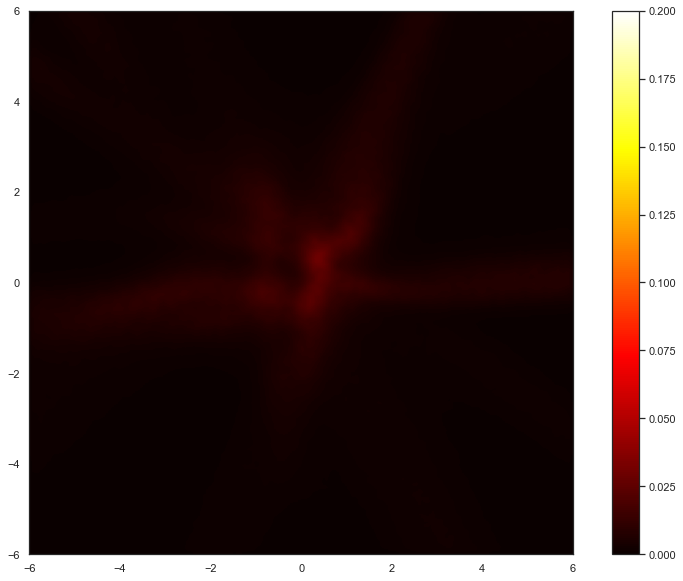

In [40]:
inputLayer = Input(shape = (2))    
decoder = inputLayer
for layer in ae.layers[7:]:
    decoder = layer(decoder)
decoder = Model(inputs=inputLayer, outputs=decoder)

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,14)})
generate_spatial_variance_map_AE(decoder, activations, [-6, 6], [-6, 6])


And here, we plot a temporal feature: how quickly on average one moves through different regions of the latent space while walking. If what we claim above is true - radius encodes cadence, then we can expect to see the outer region of the latent structure to indicate higher speeds. Sure enough, that bears out, though different phases of gait show different speeds.

(50, 50)
(50, 50)


<Figure size 1008x720 with 0 Axes>

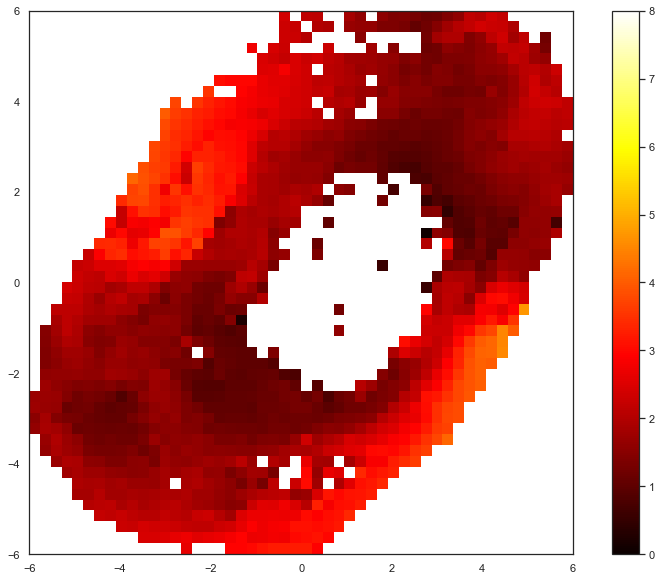

In [41]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
generate_temporal_variance_map(activations, [-6, 6], [-6, 6])

## Stairs data

In [92]:
hist = []
losses_train = []
losses_test = []
dimvar_stairs = []
ae_vaf_test_stairs = []
ae_vaf_train_stairs = []
input_dim = x_train_stairs.shape[2]
latent_dim = 2

for d in range(1,15):
    latent_dim = d
    ae = create_autoencoder_final(latent_dim, input_dim, np.clip(latent_dim,7,15))
    opt = Adam(learning_rate=0.001)
    ae.compile(loss='mse', loss_weights=1, optimizer=opt)
    ae = train_num_iterations(ae, x_train_stairs[:,0,:], x_train_stairs[:,0,:], 32, 8000)
    
    inputLayer = Input(shape = (x_train_stairs.shape[2]))    
    embedder = inputLayer
    for layer in ae.layers[:7]:
        embedder = layer(embedder)
    embedder = Model(inputs=inputLayer, outputs=embedder)
    activations = embedder(x_train_stairs[:,0,:])
    
    dimvartemp = []
    for u in range(activations.shape[1]):
        dimvartemp.append(np.var(activations[:,u]))
    print(activations.shape)
    dimvar_stairs.append(dimvartemp)
    
    dec = ae.predict(x_test_stairs[:,0,:])
    loss = ((x_test_stairs[:,0,:] - dec) ** 2).mean()
    losses_test.append(loss)
    ae_vaf_test_stairs.append((1 - ((np.var(x_test_stairs[:,0,:] - dec)) / (np.var(x_test_stairs[:,0,:])))) * 100)
    
    dec = ae.predict(x_train_stairs[:,0,:])
    loss = ((x_train_stairs[:,0,:] - dec) ** 2).mean()
    losses_train.append(loss)
    ae_vaf_train_stairs.append((1 - ((np.var(x_train_stairs[:,0,:] - dec)) / (np.var(x_train_stairs[:,0,:])))) * 100)
    
    print('Latent dim: ' + str(d) + ' with train loss: ' + str(loss))

(54755, 1). 99.99%
Latent dim: 1 with train loss: 0.4915270881713231
(54755, 2). 99.99%
Latent dim: 2 with train loss: 0.41440364680121433
(54755, 3). 99.99%
Latent dim: 3 with train loss: 0.3386351603241217
(54755, 4). 99.99%
Latent dim: 4 with train loss: 0.26242015029811394
(54755, 5). 99.99%
Latent dim: 5 with train loss: 0.24964771584724962
(54755, 6). 99.99%
Latent dim: 6 with train loss: 0.2262328412162691
(54755, 7). 99.99%
Latent dim: 7 with train loss: 0.1758707363998012
(54755, 8). 99.99%
Latent dim: 8 with train loss: 0.17478342417942333
(54755, 9). 99.99%
Latent dim: 9 with train loss: 0.11201294663898949
(54755, 10) 99.99%
Latent dim: 10 with train loss: 0.08329587577347182
(54755, 11) 99.99%
Latent dim: 11 with train loss: 0.08394006899127752
(54755, 12) 99.99%
Latent dim: 12 with train loss: 0.06198259078377007
(54755, 13) 99.99%
Latent dim: 13 with train loss: 0.04537901622160999
(54755, 14) 99.99%
Latent dim: 14 with train loss: 0.04632639151596856


### Train a model for safekeeping

In [60]:
input_dim = x_train_stairs.shape[2]
latent_dim = 2
ae = create_autoencoder_final(2, input_dim, 7)
opt = Adam(learning_rate=0.001)
ae.compile(loss='mse', loss_weights=1, optimizer=opt)
ae.fit(x_train_stairs[:,0,:], x_train_stairs[:,0,:], epochs = 25, batch_size = 32, verbose = 0)
ae.save('models/ae-stairs.h5')


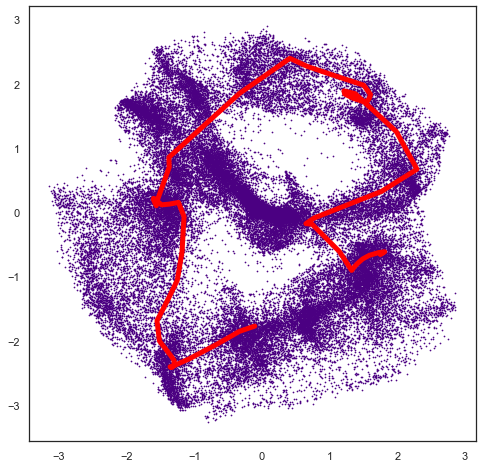

In [93]:
ae = keras.models.load_model('models/ae-stairs.h5')
inputLayer = Input(shape = (x_train_stairs.shape[2]))    
embedder = inputLayer
for layer in ae.layers[:7]:
    embedder = layer(embedder)
embedder = Model(inputs=inputLayer, outputs=embedder)
activations = embedder(x_train_stairs[:,0,:])

sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})
plt.scatter(activations[:,0],activations[:,1],s=0.5,color = 'indigo')

#Get a random sequence and plot it
cycleSample = []
for t in range(60):
    acts = embedder(x_train_stairs[1000:1001,t,:])
    cycleSample.append(acts)
plt.plot(np.squeeze(np.array(cycleSample))[:,0],np.squeeze(np.array(cycleSample))[:,1], color = 'red', linewidth = 5)

(50, 50)
(50, 50)


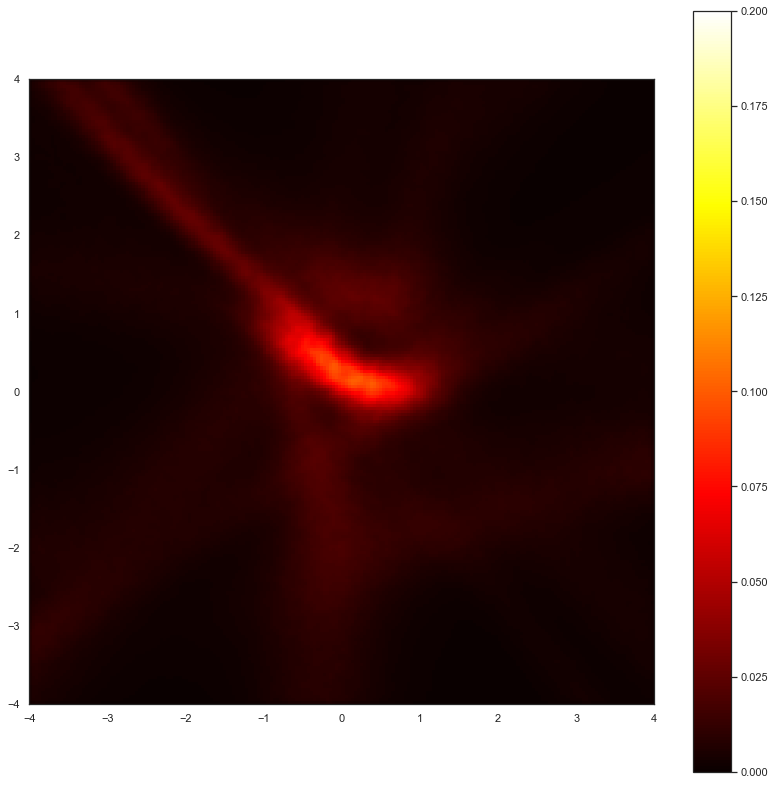

<Figure size 1008x1008 with 0 Axes>

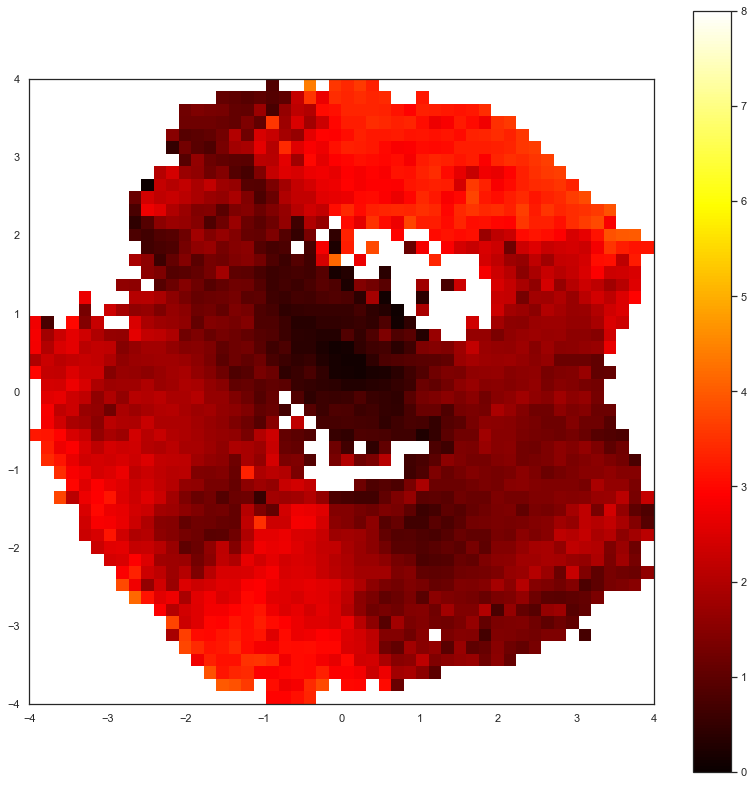

In [94]:
inputLayer = Input(shape = (2))    
decoder = inputLayer
for layer in ae.layers[7:]:
    decoder = layer(decoder)
decoder = Model(inputs=inputLayer, outputs=decoder)

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,14)})
generate_spatial_variance_map_AE(decoder, activations, [-4, 4], [-4, 4])
generate_temporal_variance_map(activations, [-4, 4], [-4, 4])

## Unstructured data

In [101]:
hist = []
losses_test = []
losses_train = []
dimvar_unstructured = []
ae_vaf_test_unstructured = []
ae_vaf_train_unstructured = []
input_dim = x_train_unstructured.shape[1]
latent_dim = 2

for d in range(1,15):
    latent_dim = d
    ae = create_autoencoder_final(latent_dim, input_dim, np.clip(latent_dim,7,15))
    opt = Adam(learning_rate=0.001)
    ae.compile(loss='mse', loss_weights=1, optimizer=opt)
    ae = train_num_iterations(ae, x_train_unstructured, x_train_unstructured, 32, 8000)
    
    inputLayer = Input(shape = (x_train_unstructured.shape[1]))    
    embedder = inputLayer
    for layer in ae.layers[:7]:
        embedder = layer(embedder)
    embedder = Model(inputs=inputLayer, outputs=embedder)
    activations = embedder(x_train_unstructured)
    
    dimvartemp = []
    for u in range(activations.shape[1]):
        dimvartemp.append(np.var(activations[:,u]))
    print(activations.shape)
    dimvar_unstructured.append(dimvartemp)
    
    
    dec = ae.predict(x_test_unstructured)
    loss = ((x_test_unstructured - dec) ** 2).mean()
    losses_test.append(loss)
    ae_vaf_test_unstructured.append((1 - ((np.var(x_test_unstructured - dec)) / (np.var(x_test_unstructured)))) * 100)
    
    dec = ae.predict(x_train_unstructured)
    loss = ((x_train_unstructured - dec) ** 2).mean()
    losses_train.append(loss)
    ae_vaf_train_unstructured.append((1 - ((np.var(x_train_unstructured - dec)) / (np.var(x_train_unstructured)))) * 100)
    
    print('Latent dim: ' + str(d) + ' with train loss: ' + str(loss))

(34779, 1). 99.99%
Latent dim: 1 with train loss: 1.1634817991551265
(34779, 2). 99.99%
Latent dim: 2 with train loss: 0.975245512150544
(34779, 3). 99.99%
Latent dim: 3 with train loss: 0.8585416172906933
(34779, 4). 99.99%
Latent dim: 4 with train loss: 0.7150131720406824
(34779, 5). 99.99%
Latent dim: 5 with train loss: 0.6162850206755017
(34779, 6). 99.99%
Latent dim: 6 with train loss: 0.5446244412178842
(34779, 7). 99.99%
Latent dim: 7 with train loss: 0.5255886926415781
(34779, 8). 99.99%
Latent dim: 8 with train loss: 0.44391497468037316
(34779, 9). 99.99%
Latent dim: 9 with train loss: 0.3517657391807759
(34779, 10) 99.99%
Latent dim: 10 with train loss: 0.27343195366356704
(34779, 11) 99.99%
Latent dim: 11 with train loss: 0.2820771706145936
(34779, 12) 99.99%
Latent dim: 12 with train loss: 0.1846218175757466
(34779, 13) 99.99%
Latent dim: 13 with train loss: 0.17566180344958324
(34779, 14) 99.99%
Latent dim: 14 with train loss: 0.13789031398748058


### Generate 2d embedding

In [64]:
input_dim = x_train_flat.shape[1]
latent_dim = 2
ae = create_autoencoder_final(2, input_dim, 7)
opt = Adam(learning_rate=0.001)
ae.compile(loss='mse', loss_weights=1, optimizer=opt)
ae.fit(x_train_unstructured, x_train_unstructured, epochs = 25, batch_size = 32, verbose = 0)
ae.save('models/ae-unstructured.h5')

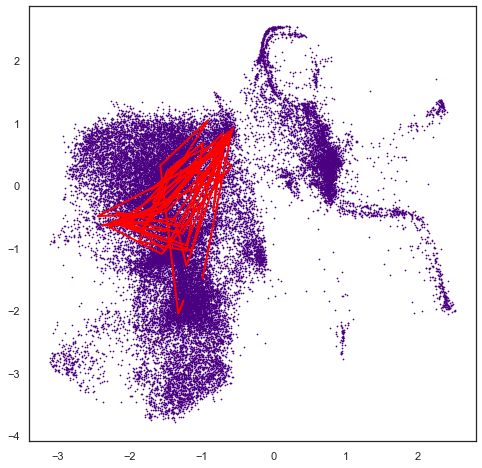

In [58]:
ae = keras.models.load_model('models/ae-unstructured.h5')
inputLayer = Input(shape = (x_train_unstructured.shape[1]))    
embedder = inputLayer
for layer in ae.layers[:7]:
    embedder = layer(embedder)
embedder = Model(inputs=inputLayer, outputs=embedder)
activations = embedder(x_train_unstructured)

sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})
plt.scatter(activations[:,0],activations[:,1],s=0.5,color = 'indigo')
#plt.savefig('figs/AE_2d_embedding_unstructured.png')

#Get a random sequence and plot it
cycleSample = []
for t in range(60):
    acts = embedder(x_train_unstructured[t+1000:t+1001,:])
    cycleSample.append(acts)
plt.plot(np.squeeze(np.array(cycleSample))[:,0],np.squeeze(np.array(cycleSample))[:,1], color = 'red', linewidth = 2)

(50, 50)
(50, 50)


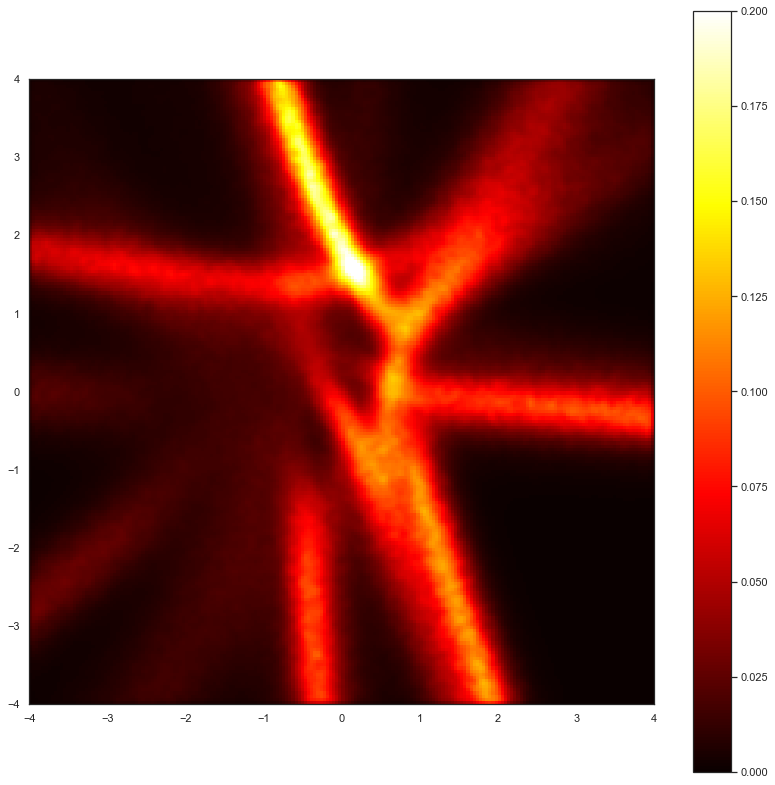

<Figure size 1008x1008 with 0 Axes>

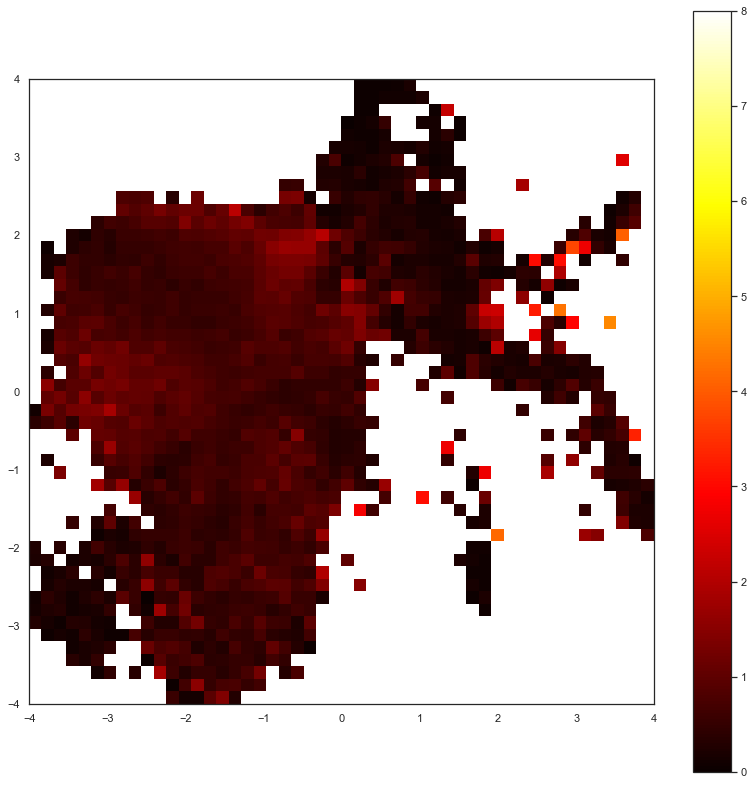

In [59]:
inputLayer = Input(shape = (2))    
decoder = inputLayer
for layer in ae.layers[7:]:
    decoder = layer(decoder)
decoder = Model(inputs=inputLayer, outputs=decoder)

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,14)})
generate_spatial_variance_map_AE(decoder, activations, [-4, 4], [-4, 4])
generate_temporal_variance_map(activations, [-4, 4], [-4, 4])

## Combined dataset

When datasets are combined, our model simply does not have capacity to represent the full complexity of movements. Below, we train a model on all datasets and visualize the latent space. Unlike before, a single flatground gait cycle is broken into two regions, and the latent space shows multiple fractures as the encoder attempts to segment out various types of movements.

In [62]:
input_dim = 14
latent_dim = 2

x_combined = np.vstack([x_train_flat[:,0,:], x_train_stairs[:,0,:], x_train_unstructured])

ae = create_autoencoder_final(2, input_dim, 7)
opt = Adam(learning_rate=0.001)
ae.compile(loss='mse', loss_weights=1, optimizer=opt)
ae.fit(x_combined, x_combined, epochs = 25, batch_size = 32, verbose = 0, shuffle = True) #adjust parameters accordingly
#ae.save('models/ae-combined.h5')

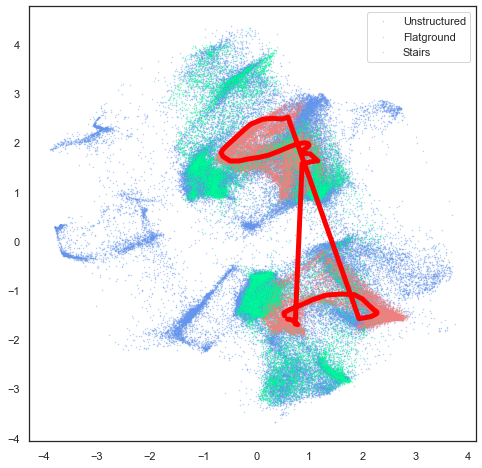

In [66]:
ae = keras.models.load_model('models/ae-combined.h5')
inputLayer = Input(shape = (x_combined.shape[1]))    
embedder = inputLayer
for layer in ae.layers[:7]:
    embedder = layer(embedder)
embedder = Model(inputs=inputLayer, outputs=embedder)
activations = embedder(x_combined)

sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})
plt.scatter(activations[x_train_stairs.shape[0]:,0],activations[x_train_stairs.shape[0]:,1],s=0.2,color = 'cornflowerblue', alpha = 0.5)
plt.scatter(activations[:x_train_flat.shape[0],0],activations[:x_train_flat.shape[0],1],s=0.2,color = 'lightcoral', alpha = 0.5)
plt.scatter(activations[x_train_flat.shape[0]:x_train_stairs.shape[0],0],activations[x_train_flat.shape[0]:x_train_stairs.shape[0],1],s=0.2,color = 'mediumspringgreen', alpha = 0.5)
plt.legend(['Unstructured','Flatground','Stairs'])
#plt.savefig('figs/AE_2d_embedding_combined.png')

#Get a random sequence and plot it
cycleSample = []
for t in range(60):
    acts = embedder(x_train_flat[1000:1001,t,:])
    cycleSample.append(acts)
plt.plot(np.squeeze(np.array(cycleSample))[:,0],np.squeeze(np.array(cycleSample))[:,1], color = 'red', linewidth = 5)

(50, 50)
(50, 50)


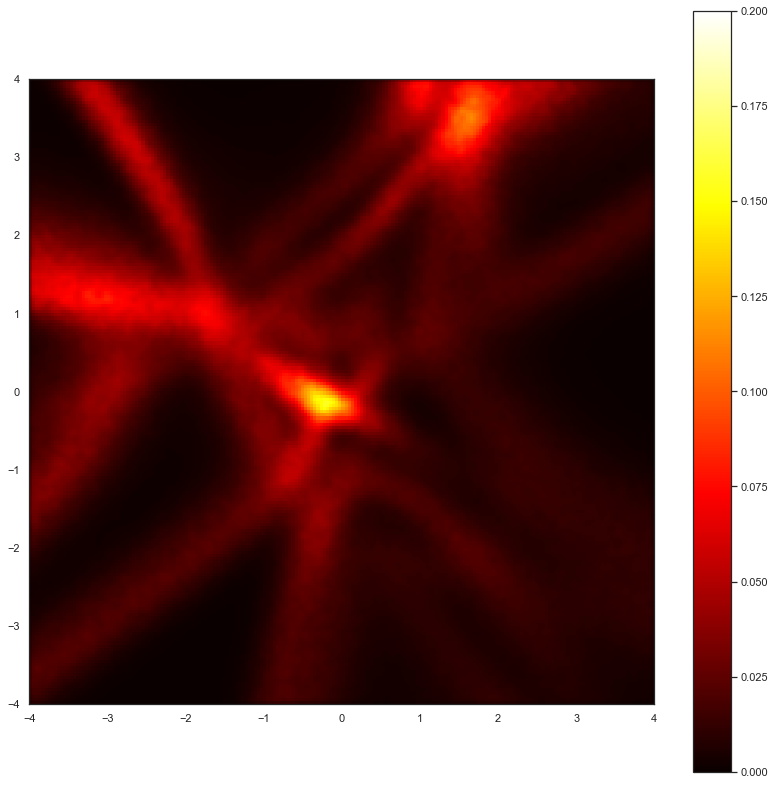

<Figure size 1008x1008 with 0 Axes>

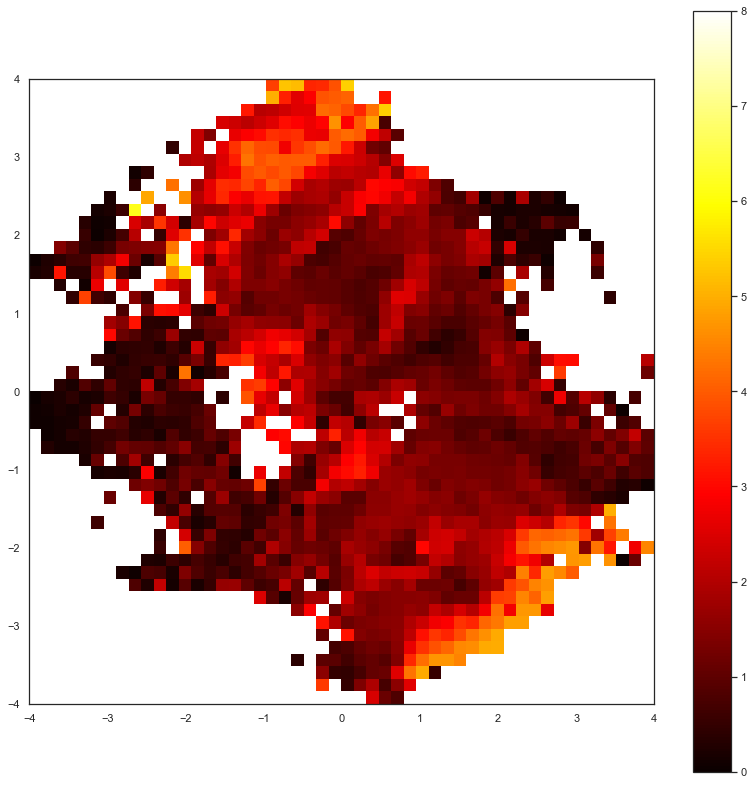

In [65]:
inputLayer = Input(shape = (2))    
decoder = inputLayer
for layer in ae.layers[7:]:
    decoder = layer(decoder)
decoder = Model(inputs=inputLayer, outputs=decoder)

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,14)})
generate_spatial_variance_map_AE(decoder, activations, [-4, 4], [-4, 4])
generate_temporal_variance_map(activations, [-4, 4], [-4, 4])

# Apply PCA

As before, we will now apply PCA to each dataset and generate some comparison plots.

Note how PCA converts gait into a cyclic structure, like the autoencoder, but the structure differs dramatically.

Autoencoders tend to outperform PCA at lower dimensions/PCs, due in large part because they attempt to share variance across multiple dimensions, rather than maximizing capture of remaining variance in subsequent dimensions like PCA. Neither technique is particularly robust to unseen data (the validation data in this case)

And, because PCA is a linear dimensionality reduction technique, the latent space is similarly linear, as the "spatial variance" plot demonstrates.

### Flatground

(50, 50)
(50, 50)


Text(0, 0.5, 'Ratio of total variance')

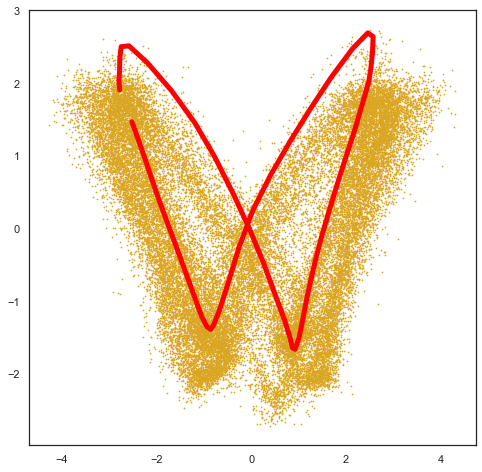

<Figure size 1008x1008 with 0 Axes>

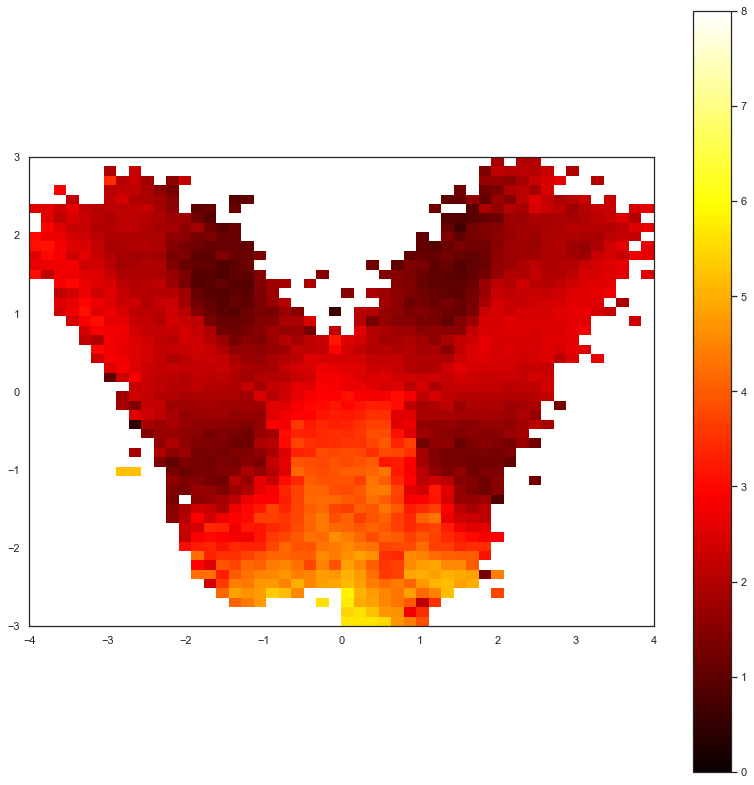

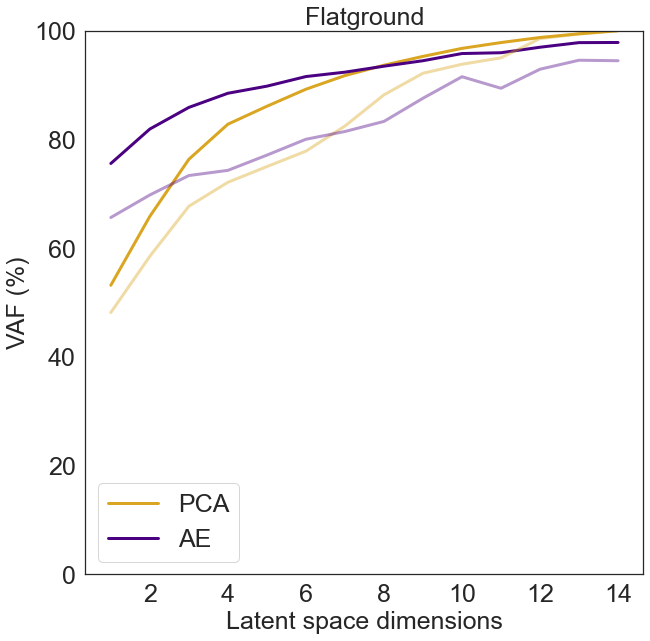

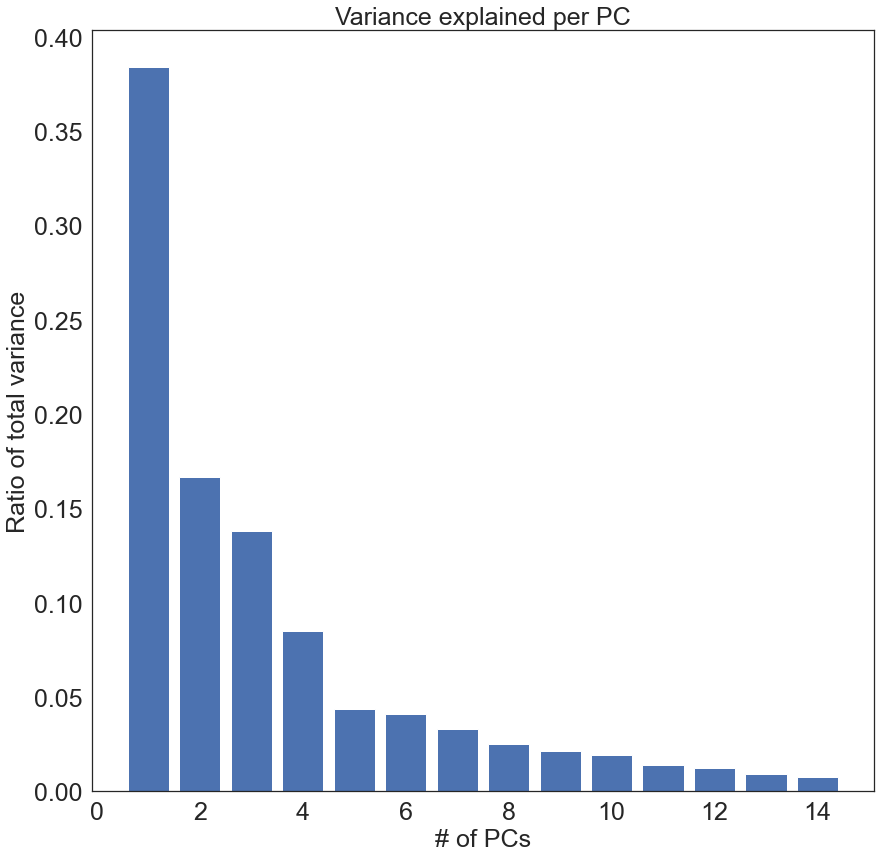

In [89]:
from sklearn.decomposition import PCA # for PCA calculation

#Get VAF for each quantity of PCs
pca_vaf_train_flat = []
pca_vaf_test_flat = []
pca_reconLoss = []
for p in range(1,15):
    pca = PCA(n_components = p)
    red = pca.fit_transform(x_train_flat[:,0,:])
    y_pca = pca.inverse_transform(red)
    redtest_pca = pca.transform(x_test_flat)
    ytest_pca = pca.inverse_transform(redtest_pca)
    loss = ((x_test_flat - ytest_pca) ** 2).mean()
    pca_reconLoss.append(loss)
    pca_vaf_test_flat.append((1 - ((np.var(x_test_flat - ytest_pca)) / (np.var(x_test_flat)))) * 100)
    pca_vaf_train_flat.append((1 - ((np.var(x_train_flat[:,0,:] - y_pca)) / (np.var(x_train_flat[:,0,:])))) * 100)
    #print(str(p) + ' components reconstruction loss: ' + str(loss))

#Plot the PCA-embedded latent space and the same gait sample as before
sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})
plt.figure(0)
cycleSample = []
plt.scatter(red[:,0],red[:,1], s = 0.5, color = 'goldenrod')
for t in range(59):
    rep1 = pca.transform(x_train_flat[1000:1001,t,:])
    cycleSample.append(rep1[:,:2])
    #plt.scatter(rep1[:,0], rep1[:,1], s = 20, color = 'black')
plt.plot(np.squeeze(np.array(cycleSample))[:,0],np.squeeze(np.array(cycleSample))[:,1], color = 'red', linewidth = 5)
#plt.savefig('figs/PCA_2d_embedding_flat.png')

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,14)})
plt.figure(1)

#generate_spatial_variance_map_PCA(pca, red, [-4, 4], [-3, 3])
generate_temporal_variance_map(red[:,:2], [-4, 4], [-3, 3])


sns.set(style='white', context='notebook', rc={'figure.figsize':(10,10)})
pca_reconPercent = [(1-x)*100 for x in pca_reconLoss]
lossesPercent = [(1-x)*100 for x in losses]

plt.figure(2)
plt.title("Flatground", fontsize = 25)
plt.plot(range(1,15), pca_vaf_train_flat,  linewidth = 3, color = 'goldenrod')
plt.plot(range(1,15), ae_vaf_train_flat, linewidth = 3, color = 'indigo')
plt.plot(range(1,15), pca_vaf_test_flat,  linewidth = 3, color = 'goldenrod', alpha = 0.4)
plt.plot(range(1,15), ae_vaf_test_flat, linewidth = 3, color = 'indigo', alpha = 0.4)
plt.xlabel("Latent space dimensions", fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.ylabel("VAF (%)", fontsize = 25)
plt.legend(['PCA','AE'], fontsize =25)
plt.ylim(0, 100)
#plt.savefig('figs/Stairs-VAF-withTest.png')

sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})
plt.figure(3)
plt.title("Variance explained per PC", fontsize = 25)
plt.bar(range(1,15),pca.explained_variance_ratio_)
plt.xlabel("# of PCs", fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.ylabel("Ratio of total variance", fontsize = 25)



### Observe how PCA and AEs share variance across dimensions

Text(0, 0.5, 'Dimension Variance Ratio')

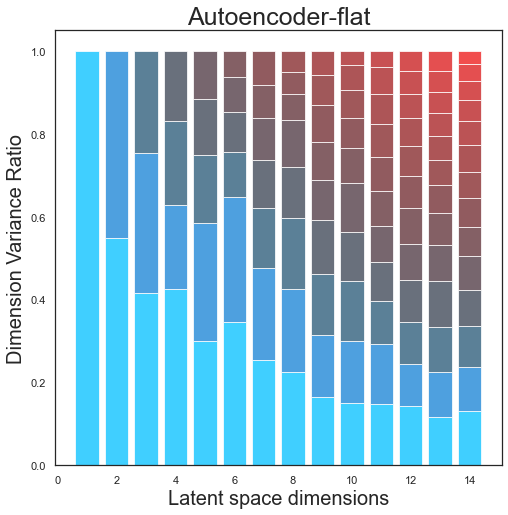

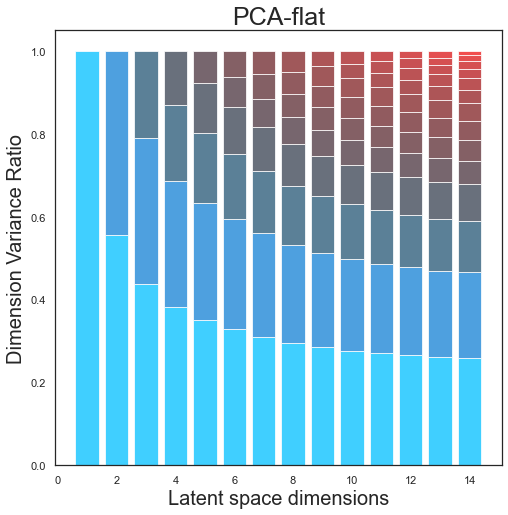

In [98]:
#Flatground Data
dimvarRatio = dimvar_flat.copy()
for d in dimvarRatio:
    d.sort(reverse = True)
for d in range(len(dimvarRatio)):
    dimvarRatio[d] = dimvarRatio[d]/sum(dimvarRatio[d])

colors = np.full((14,14), np.arange(14))
plt.figure(0)
for d in range(0, len(dimvarRatio)):
    for v in range(0,len(dimvarRatio[d])):
        if v > 0:
            plt.bar(d+1, dimvarRatio[d][v], bottom = sum(dimvarRatio[d][:v]), alpha = 0.75, color = (v/14,1/(v+1),1/(v+0.2)))
        else:
            plt.bar(d+1, dimvarRatio[d][v], alpha = 0.75, color = (v/14,0.75,1))

plt.title('Autoencoder-flat', fontsize = 25)
plt.xlabel('Latent space dimensions', fontsize = 20)
plt.ylabel('Dimension Variance Ratio', fontsize = 20)
#plt.savefig('figs/Natural-DimVar-AE.png')


plt.figure(1)
for group in range(1,15):
    for pc in range(14):
        if pc < group:
            if pc > 0:
                plt.bar(group, pca.explained_variance_ratio_[pc]/sum(pca.explained_variance_ratio_[:group]), bottom = sum(pca.explained_variance_ratio_[:pc])/sum(pca.explained_variance_ratio_[:group]), alpha = 0.75, color = (pc/14,1/(pc+1),1/(pc+0.2)))
            else:
                plt.bar(group, pca.explained_variance_ratio_[pc]/sum(pca.explained_variance_ratio_[:group]), bottom = sum(pca.explained_variance_ratio_[:pc])/sum(pca.explained_variance_ratio_[:group]), alpha = 0.75, color = (0,0.75,1))
                                
plt.title('PCA-flat', fontsize = 25)
plt.xlabel('Latent space dimensions', fontsize = 20)
plt.ylabel('Dimension Variance Ratio', fontsize = 20)
#plt.savefig('figs/Natural-DimVar-PCA.png')


### Stairs

(50, 50)
(50, 50)


Text(0, 0.5, 'Ratio of total variance')

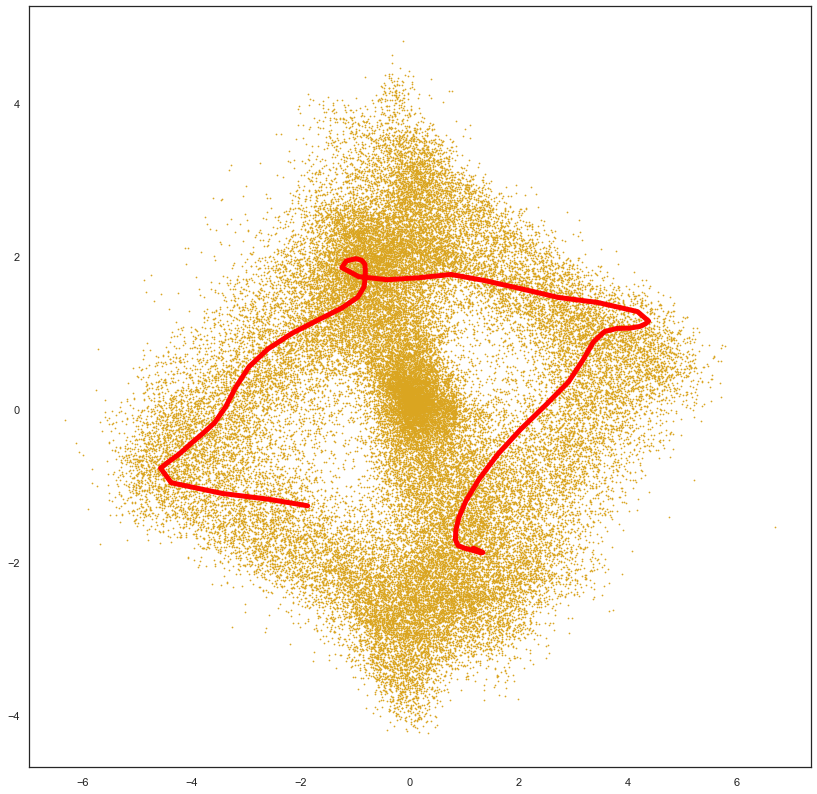

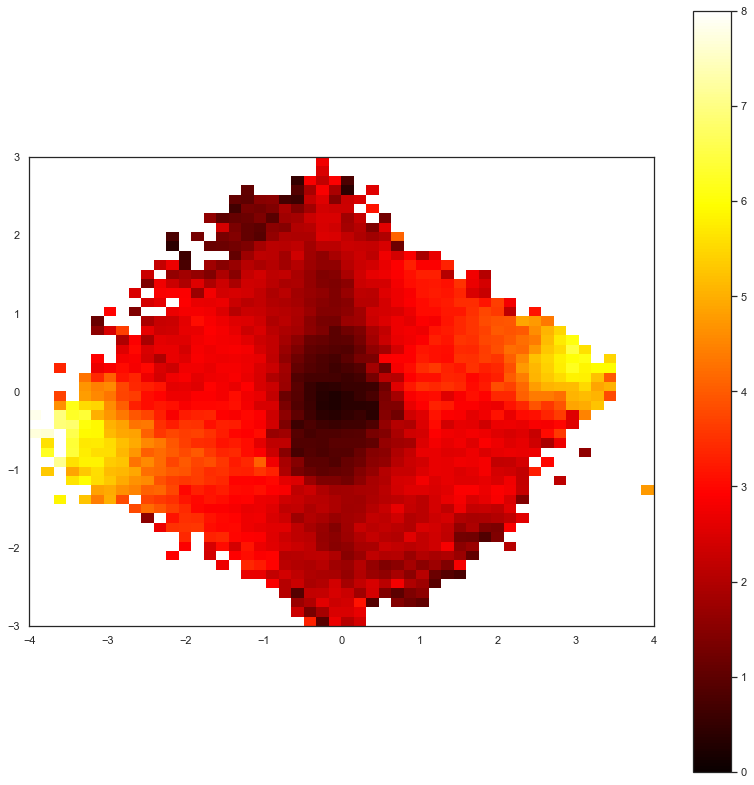

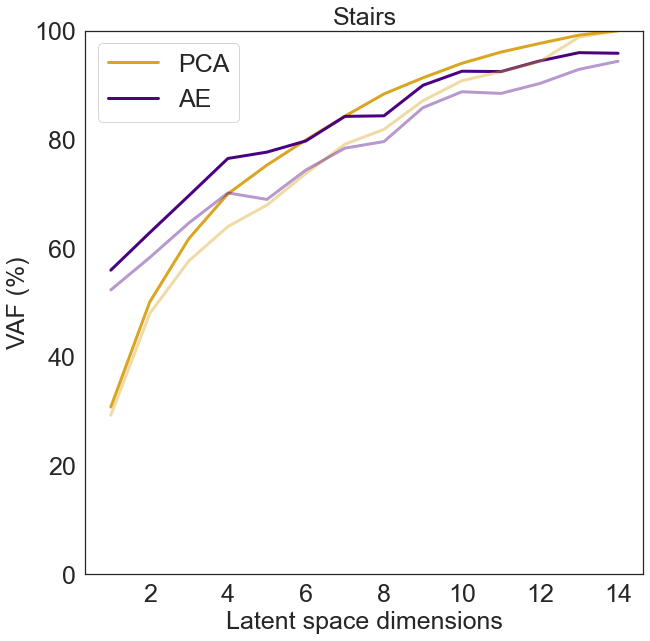

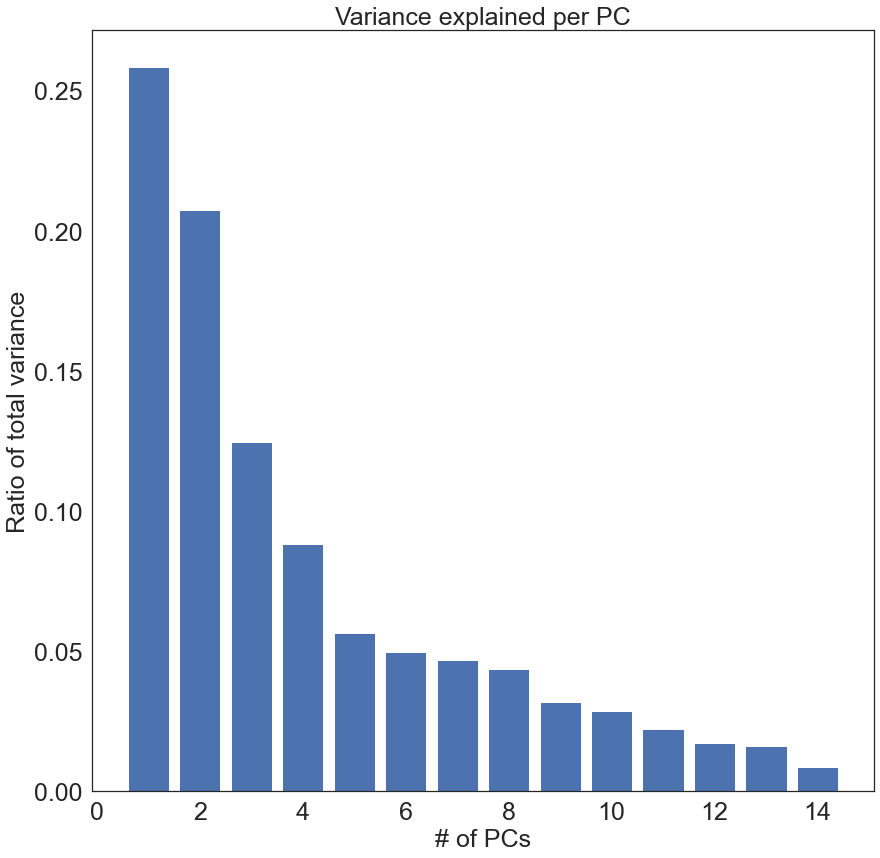

In [96]:
from sklearn.decomposition import PCA # for PCA calculation

pca_vaf_train_stairs = []
pca_vaf_test_stairs = []
pca_reconLoss = []
for p in range(1,15):
    pca = PCA(n_components = p)
    red = pca.fit_transform(x_train_stairs[:,0,:])
    y_pca = pca.inverse_transform(red)
    redtest_pca = pca.transform(x_test_stairs[:,0,:])
    ytest_pca = pca.inverse_transform(redtest_pca)
    loss = ((x_test_stairs[:,0,:] - ytest_pca) ** 2).mean()
    pca_reconLoss.append(loss)
    pca_vaf_train_stairs.append((1 - ((np.var(x_train_stairs[:,0,:] - y_pca)) / (np.var(x_train_stairs[:,0,:])))) * 100)
    pca_vaf_test_stairs.append((1 - ((np.var(x_test_stairs[:,0,:] - ytest_pca)) / (np.var(x_test_stairs[:,0,:])))) * 100)

cycleSample = []
plt.scatter(red[:,0],red[:,1], s = 0.5, color = 'goldenrod')
for t in range(59):
    rep1 = pca.transform(x_train_stairs[1000:1001,t,:])
    cycleSample.append(rep1[:,:2])
plt.plot(np.squeeze(np.array(cycleSample))[:,0],np.squeeze(np.array(cycleSample))[:,1], color = 'red', linewidth = 5)

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,14)})
plt.figure(1)
generate_temporal_variance_map(red[:,:2], [-4, 4], [-3, 3])

sns.set(style='white', context='notebook', rc={'figure.figsize':(10,10)})
plt.figure(2)
plt.title("Stairs", fontsize = 25)
plt.plot(range(1,15), pca_vaf_train_stairs,  linewidth = 3, color = 'goldenrod')
plt.plot(range(1,15), ae_vaf_train_stairs, linewidth = 3, color = 'indigo')
plt.plot(range(1,15), pca_vaf_test_stairs,  linewidth = 3, color = 'goldenrod', alpha = 0.4)
plt.plot(range(1,15), ae_vaf_test_stairs, linewidth = 3, color = 'indigo', alpha = 0.4)
plt.xlabel("Latent space dimensions", fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.ylabel("VAF (%)", fontsize = 25)
plt.legend(['PCA','AE'], fontsize =25)
plt.ylim(0, 100)
#plt.savefig('figs/Stairs-VAF-withTest.png')

sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})
plt.figure(3)
plt.title("Variance explained per PC", fontsize = 25)
plt.bar(range(1,15),pca.explained_variance_ratio_)
plt.xlabel("# of PCs", fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.ylabel("Ratio of total variance", fontsize = 25)

Text(0, 0.5, 'Dimension Variance Ratio')

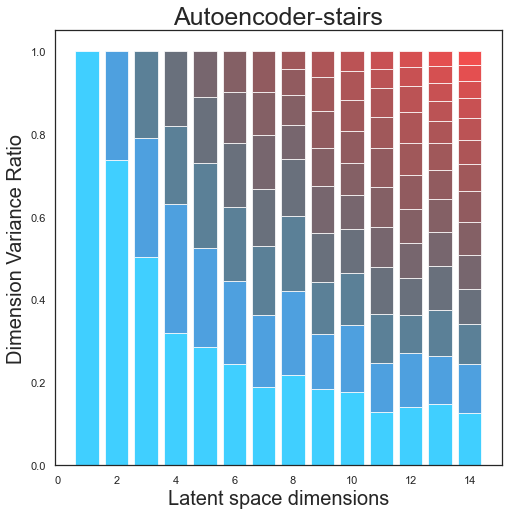

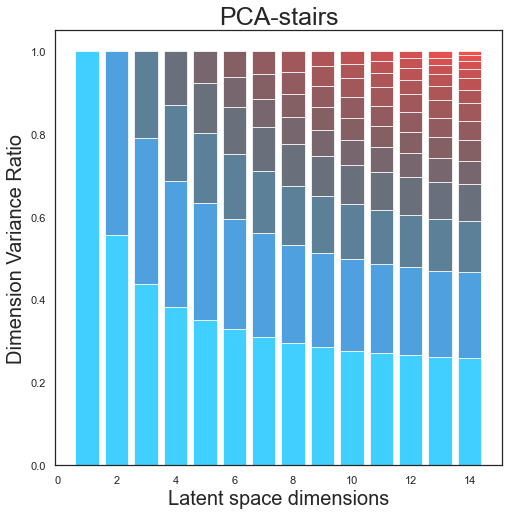

In [97]:
#Stairs Data
dimvarRatio = dimvar_stairs.copy()
for d in dimvarRatio:
    d.sort(reverse = True)
for d in range(len(dimvarRatio)):
    dimvarRatio[d] = dimvarRatio[d]/sum(dimvarRatio[d])

colors = np.full((14,14), np.arange(14))
plt.figure(0)
for d in range(0, len(dimvarRatio)):
    for v in range(0,len(dimvarRatio[d])):
        if v > 0:
            plt.bar(d+1, dimvarRatio[d][v], bottom = sum(dimvarRatio[d][:v]), alpha = 0.75, color = (v/14,1/(v+1),1/(v+0.2)))
        else:
            plt.bar(d+1, dimvarRatio[d][v], alpha = 0.75, color = (v/14,0.75,1))

plt.title('Autoencoder-stairs', fontsize = 25)
plt.xlabel('Latent space dimensions', fontsize = 20)
plt.ylabel('Dimension Variance Ratio', fontsize = 20)
#plt.savefig('figs/Natural-DimVar-AE.png')


plt.figure(1)
for group in range(1,15):
    for pc in range(14):
        if pc < group:
            if pc > 0:
                plt.bar(group, pca.explained_variance_ratio_[pc]/sum(pca.explained_variance_ratio_[:group]), bottom = sum(pca.explained_variance_ratio_[:pc])/sum(pca.explained_variance_ratio_[:group]), alpha = 0.75, color = (pc/14,1/(pc+1),1/(pc+0.2)))
            else:
                plt.bar(group, pca.explained_variance_ratio_[pc]/sum(pca.explained_variance_ratio_[:group]), bottom = sum(pca.explained_variance_ratio_[:pc])/sum(pca.explained_variance_ratio_[:group]), alpha = 0.75, color = (0,0.75,1))
                                
plt.title('PCA-stairs', fontsize = 25)
plt.xlabel('Latent space dimensions', fontsize = 20)
plt.ylabel('Dimension Variance Ratio', fontsize = 20)
#plt.savefig('figs/Natural-DimVar-PCA.png')


### Unstructured

(50, 50)
(50, 50)


Text(0, 0.5, 'Ratio of total variance')

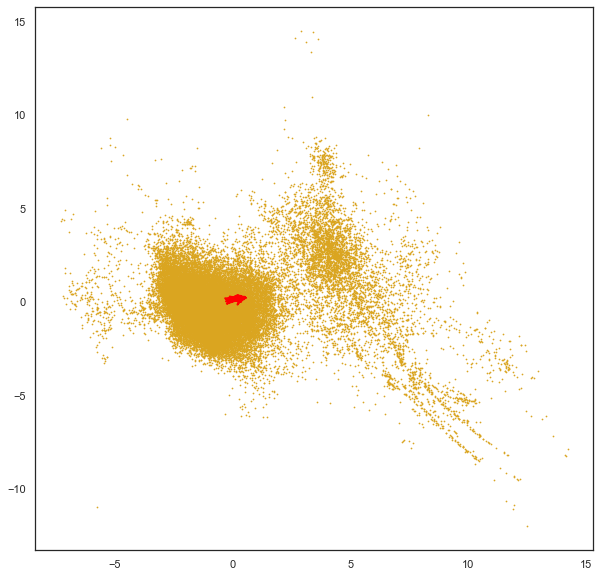

<Figure size 720x720 with 0 Axes>

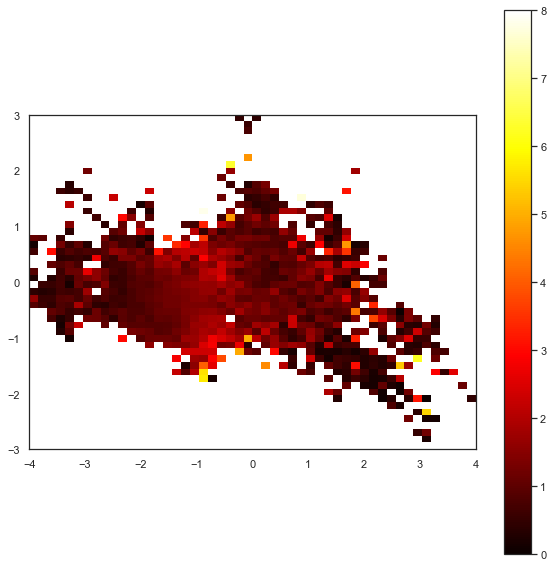

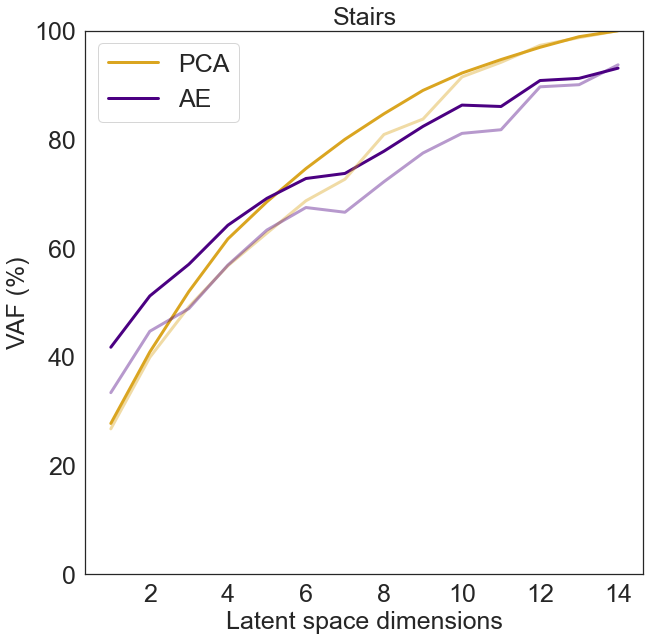

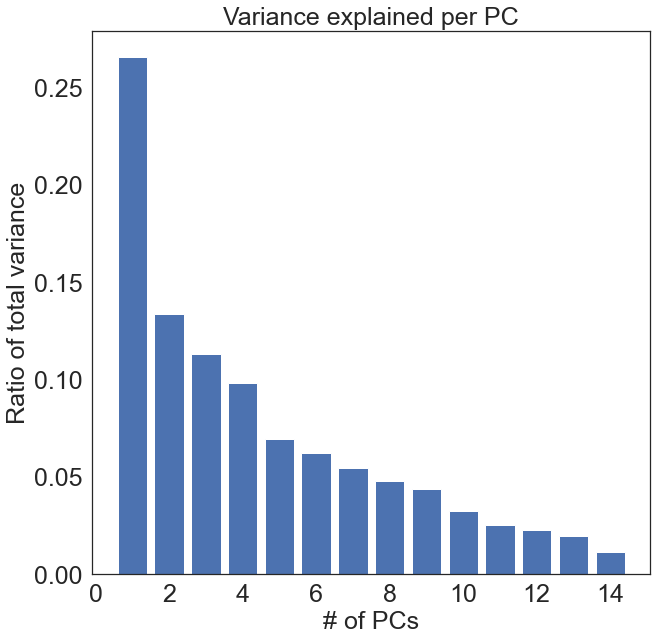

In [102]:
from sklearn.decomposition import PCA # for PCA calculation

pca_vaf_train_unstructured = []
pca_vaf_test_unstructured = []
pca_reconLoss = []
for p in range(1,15):
    pca = PCA(n_components = p)
    red = pca.fit_transform(x_train_unstructured)
    #print(red.shape)
    y_pca = pca.inverse_transform(red)
    #print(y_pca.shape)
    redtest_pca = pca.transform(x_test_unstructured)
    ytest_pca = pca.inverse_transform(redtest_pca)
    loss = ((x_test_unstructured - ytest_pca) ** 2).mean()
    pca_reconLoss.append(loss)
    pca_vaf_test_unstructured.append((1 - ((np.var(x_test_unstructured - ytest_pca)) / (np.var(x_test_unstructured )))) * 100)
    pca_vaf_train_unstructured.append((1 - ((np.var(x_train_unstructured - y_pca)) / (np.var(x_train_unstructured )))) * 100)
    #print(str(p) + ' components reconstruction loss: ' + str(loss))

plt.figure(0)
cycleSample = []
plt.scatter(red[:,0],red[:,1], s = 0.5, color = 'goldenrod')
#Get a random sequence and plot it
cycleSample = []
for t in range(60):
    acts = embedder(x_train_unstructured[t+1000:t+1001,:])
    cycleSample.append(acts)
plt.plot(np.squeeze(np.array(cycleSample))[:,0],np.squeeze(np.array(cycleSample))[:,1], color = 'red', linewidth = 2)

plt.figure(1)
generate_temporal_variance_map(red[:,:2], [-4, 4], [-3, 3])

sns.set(style='white', context='notebook', rc={'figure.figsize':(10,10)})
plt.figure(2)
plt.title("Stairs", fontsize = 25)
plt.plot(range(1,15), pca_vaf_train_unstructured,  linewidth = 3, color = 'goldenrod')
plt.plot(range(1,15), ae_vaf_train_unstructured, linewidth = 3, color = 'indigo')
plt.plot(range(1,15), pca_vaf_test_unstructured,  linewidth = 3, color = 'goldenrod', alpha = 0.4)
plt.plot(range(1,15), ae_vaf_test_unstructured, linewidth = 3, color = 'indigo', alpha = 0.4)
plt.xlabel("Latent space dimensions", fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.ylabel("VAF (%)", fontsize = 25)
plt.legend(['PCA','AE'], fontsize =25)
plt.ylim(0, 100)
#plt.savefig('figs/Stairs-VAF-withTest.png')

sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})
plt.figure(3)
plt.title("Variance explained per PC", fontsize = 25)
plt.bar(range(1,15),pca.explained_variance_ratio_)
plt.xlabel("# of PCs", fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.ylabel("Ratio of total variance", fontsize = 25)

Text(0, 0.5, 'Dimension Variance Ratio')

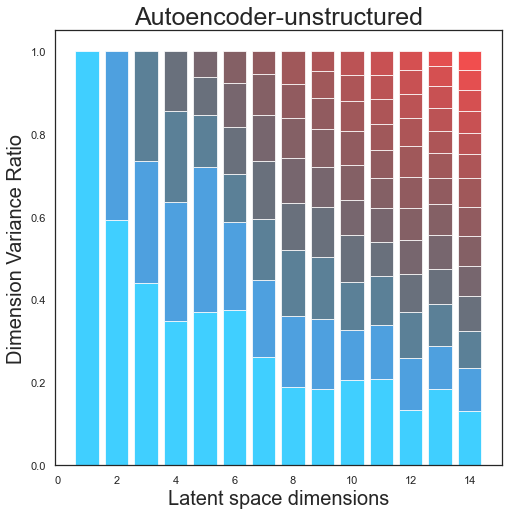

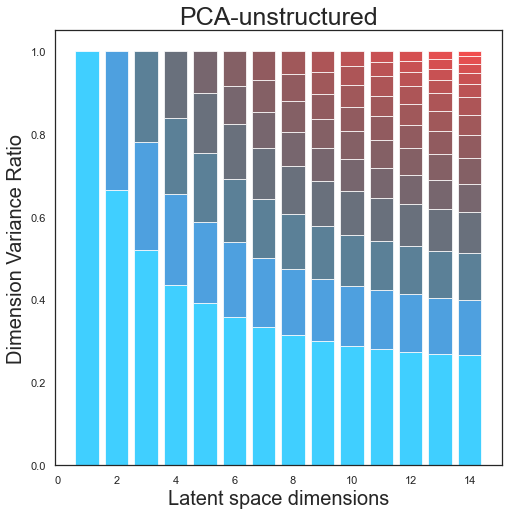

In [103]:
#Unstructured Data
dimvarRatio = dimvar_unstructured.copy()
for d in dimvarRatio:
    d.sort(reverse = True)
for d in range(len(dimvarRatio)):
    dimvarRatio[d] = dimvarRatio[d]/sum(dimvarRatio[d])

colors = np.full((14,14), np.arange(14))
plt.figure(0)
for d in range(0, len(dimvarRatio)):
    for v in range(0,len(dimvarRatio[d])):
        if v > 0:
            plt.bar(d+1, dimvarRatio[d][v], bottom = sum(dimvarRatio[d][:v]), alpha = 0.75, color = (v/14,1/(v+1),1/(v+0.2)))
        else:
            plt.bar(d+1, dimvarRatio[d][v], alpha = 0.75, color = (v/14,0.75,1))

plt.title('Autoencoder-unstructured', fontsize = 25)
plt.xlabel('Latent space dimensions', fontsize = 20)
plt.ylabel('Dimension Variance Ratio', fontsize = 20)
#plt.savefig('figs/Natural-DimVar-AE.png')


plt.figure(1)
for group in range(1,15):
    for pc in range(14):
        if pc < group:
            if pc > 0:
                plt.bar(group, pca.explained_variance_ratio_[pc]/sum(pca.explained_variance_ratio_[:group]), bottom = sum(pca.explained_variance_ratio_[:pc])/sum(pca.explained_variance_ratio_[:group]), alpha = 0.75, color = (pc/14,1/(pc+1),1/(pc+0.2)))
            else:
                plt.bar(group, pca.explained_variance_ratio_[pc]/sum(pca.explained_variance_ratio_[:group]), bottom = sum(pca.explained_variance_ratio_[:pc])/sum(pca.explained_variance_ratio_[:group]), alpha = 0.75, color = (0,0.75,1))
                                
plt.title('PCA-unstructured', fontsize = 25)
plt.xlabel('Latent space dimensions', fontsize = 20)
plt.ylabel('Dimension Variance Ratio', fontsize = 20)
#plt.savefig('figs/Natural-DimVar-PCA.png')


# Reconstruction by dataset

So far we have only looked at characteristics of the latent spaces, but what about reconstruction quality between PCA inverse transform and the decoder? We can judge reconstruction performance from the bottleneck fairly easily. Results are plotted below.

### Get reconstruction loss, plot by dataset

In [106]:
from sklearn.decomposition import PCA # for PCA calculation

# Generate PCA predictions, calculate error
pca = PCA(n_components = 2)
red = pca.fit_transform(x_train_flat[:,0,:])
red = pca.transform(x_test_flat)
y_pca = pca.inverse_transform(red)
loss_flat_pca = np.sqrt(np.mean((x_test_flat - y_pca)**2))
print(loss_flat_pca)

pca = PCA(n_components = 2)
red = pca.fit_transform(x_train_stairs[:,0,:])
red = pca.transform(x_test_stairs[:,0,:])
y_pca = pca.inverse_transform(red)
loss_stairs_pca = np.sqrt(np.mean((x_test_stairs[:,0,:] - y_pca)**2))
print(loss_stairs_pca)

pca = PCA(n_components = 2)
red = pca.fit_transform(x_train_unstructured)
red = pca.transform(x_test_unstructured)
y_pca = pca.inverse_transform(red)
loss_natural_pca = np.sqrt(np.mean((x_test_unstructured - y_pca)**2))
print(loss_natural_pca)

0.6340338838842017
0.7979952950855165
1.052266664373095


In [108]:
losses_flat = []
for r in range(10):
    ae = create_autoencoder_final(2, 14, 7)
    opt = Adam(learning_rate=0.001)
    ae.compile(loss='mse', loss_weights=1, optimizer=opt)
    ae = train_num_iterations(ae, x_train_flat[:,0,:], x_train_flat[:,0,:], 32, 8000)
    aeflat_dec = ae.predict(x_test_flat)
    loss_flat_ae = np.sqrt(np.mean((x_test_flat - aeflat_dec)**2))
    print(loss_flat_ae)
    losses_flat.append(loss_flat_ae)

0.5509772886571827
0.530229168750256%
0.5377319008687078
0.5375322079670162
0.5578327148567334
0.5494551400257054
0.5496927427540469
0.5584832109271098
0.5502619940117037
0.5326209695991229


In [111]:
losses_stairs = []
for r in range(10):
    ae = create_autoencoder_final(2, 14, 7)
    opt = Adam(learning_rate=0.001)
    ae.compile(loss='mse', loss_weights=1, optimizer=opt)
    ae = train_num_iterations(ae, x_train_stairs[:,0,:], x_train_stairs[:,0,:], 32, 8000)
    aestairs_dec = ae.predict(x_test_stairs[:,0,:])
    loss_stairs_ae = np.sqrt(np.mean((x_test_stairs[:,0,:] - aestairs_dec)**2))
    print(loss_stairs_ae)
    losses_stairs.append(loss_stairs_ae)

0.7076060325200941
0.7079762169895479
0.7046924218756891
0.7073788669348917
0.7058836208971772
0.705917798931271%
0.7088012157632829
0.7064999644199115
0.7091249669693721
0.7067833248565135


In [112]:
losses_natural = []
for r in range(10):
    ae = create_autoencoder_final(2, 14, 7)
    opt = Adam(learning_rate=0.001)
    ae.compile(loss='mse', loss_weights=1, optimizer=opt)
    ae = train_num_iterations(ae, x_train_unstructured, x_train_unstructured, 32, 8000)
    aenatural_dec = ae.predict(x_test_unstructured)
    loss_natural_ae = np.sqrt(np.mean((x_test_unstructured - aenatural_dec)**2))
    print(loss_natural_ae)
    losses_natural.append(loss_natural_ae)

1.0034844676749484
1.0429819543088545
0.9972144159339404
1.019552838927936%
1.0096209844437198
1.0344089572092683
1.0113448242545435
1.0346405926645896
1.0088895854024784
1.0149536473649252


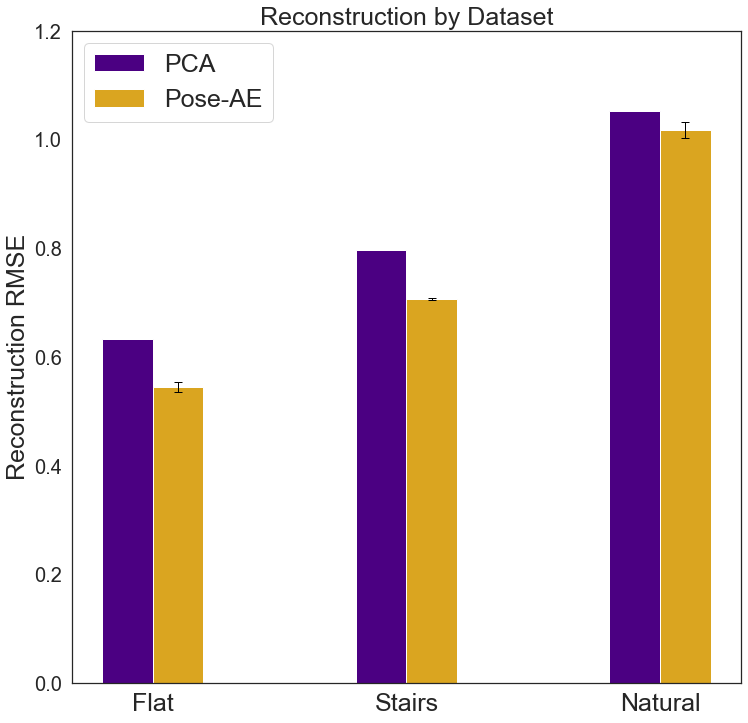

In [115]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(12,12)})
heights = [loss_flat_pca, np.mean(losses_flat), loss_stairs_pca, np.mean(losses_stairs), loss_natural_pca, np.mean(losses_natural)]
places = [-0.1, 0.1, 0.9, 1.1, 1.9, 2.1]
stds = [0, np.std(losses_flat), 0, np.std(losses_stairs), 0, np.std(losses_natural)]
plt.ylim(0,1.2)

# flat
plt.bar(places[0], heights[0], width = 0.2, align='center', color = 'indigo');
plt.bar(places[1], heights[1], width = 0.2, align='center', color = 'goldenrod');
plt.errorbar(places[1], heights[1], stds[1], capsize = 4, capthick = 1, linewidth = 1, linestyle='None', color = 'black', barsabove =False);

# stairs
plt.bar(places[2], heights[2], width = 0.2, align='center', color = 'indigo');
plt.bar(places[3], heights[3], width = 0.2, align='center', color = 'goldenrod');
plt.errorbar(places[3], heights[3], stds[3], capsize = 4, capthick = 1, linewidth = 1, linestyle='None', color = 'black', barsabove =False);

# natural
plt.bar(places[4], heights[4], width = 0.2, align='center', color = 'indigo');
plt.bar(places[5], heights[5], width = 0.2, align='center', color = 'goldenrod');
plt.errorbar(places[5], heights[5], stds[5], capsize = 4, capthick = 1, linewidth = 1, linestyle='None', color = 'black', barsabove =False);

plt.xticks([0,1,2], ['Flat','Stairs','Natural'], fontsize=25);
plt.yticks(fontsize=20);
plt.ylabel('Reconstruction RMSE', fontsize = 25)
plt.title('Reconstruction by Dataset', fontsize = 25)
plt.legend(['PCA','Pose-AE'], fontsize = 25)

#plt.savefig('figs/Barchart-Recon.png')